## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'spaceNet-full' 
TRANSFORM = 'fourier'
CHANNEL = 'red'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
red_fourier_full_spaceNet.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'c:\\Users\\riyap\\OneDrive\\Documents\\GitHub\\hierarchical-bayesian-model-validation\\results\\case-studies\\spaceNet\\full\\fourier\\red'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 47614,
 3: 54416,
 4: 61218,
 5: 102030,
 6: 156446,
 7: 197258,
 8: 326496,
 9: 421724,
 10: 639388,
 11: 904666,
 12: 1312786,
 13: 1904560,
 14: 2727602,
 15: 3958764,
 16: 5720482,
 17: 8298440,
 18: 11957916,
 19: 17270278,
 20: 25140192,
 21: 36322680,
 22: 52586262,
 23: 65734528,
 24: 32003410}

Running 12760 CDFs


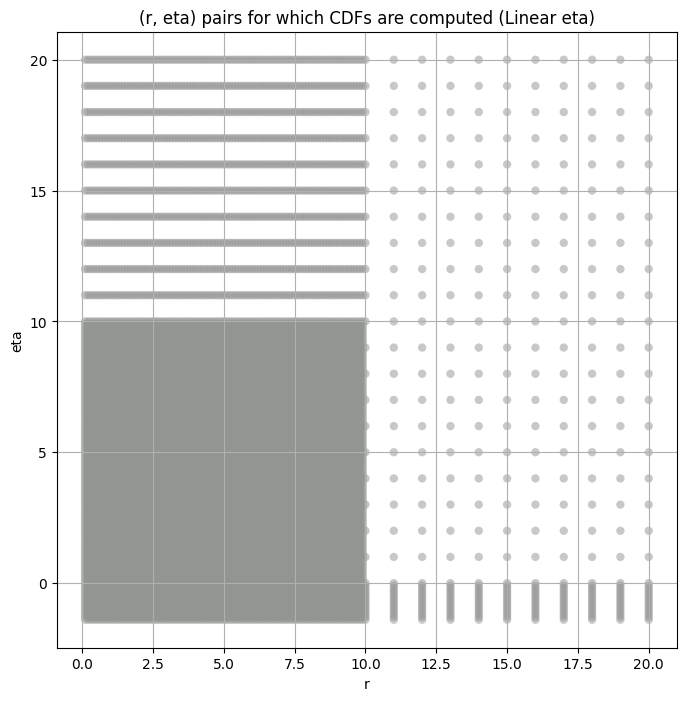

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  3%|▎         | 2880/100000 [00:00<00:22, 4307.31it/s]

100%|██████████| 100000/100000 [01:25<00:00, 1168.66it/s]


Band 5


100%|██████████| 100000/100000 [01:17<00:00, 1288.57it/s]


Band 8


100%|██████████| 100000/100000 [01:17<00:00, 1291.24it/s]


Band 11


100%|██████████| 100000/100000 [01:34<00:00, 1061.73it/s]


Band 14


100%|██████████| 100000/100000 [01:21<00:00, 1227.35it/s]


Band 17


100%|██████████| 100000/100000 [01:22<00:00, 1216.68it/s]


Band 20


100%|██████████| 100000/100000 [01:30<00:00, 1104.76it/s]


Band 23


100%|██████████| 100000/100000 [01:43<00:00, 966.61it/s]


obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
band                                                                  
2     1179.389800  1097.971300  1266.585400    5.769592    4.088153   
5      437.022400   401.945200   476.607120    8.911059    5.411635   
8      126.231570   115.505930   139.046250   10.603689    5.844242   
11      33.334743    30.622417    36.353336    9.182022    5.623512   
14      10.371416     9.499190    11.419547   10.649118    5.947791   
17       2.548775     2.287402     3.145427   34.724674    6.520165   
20       0.429869     0.363122     0.795385  315.785900    6.707437   
23       0.100375     0.091152     0.128039   39.690784    4.401588   

       kurt_upper  total_samples  
band                              
2        8.210641        47614.0  
5       14.530110       102030.0  
8       28.603450       326496.0  
11      17.436111       904666.0  
14      27.891129      2727602.0  
17     200.073500      8298440.0  
20    1304.634400     25140192.0  
23     247.719670     65734528.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
band                                                               
2     1179.389800    1179.389771     1122.128174     1087.567383   
5      437.022400     437.022400      419.128693      409.248169   
8      126.231570     126.231567      120.722839      117.818390   
11      33.334743      33.334743       31.994476       31.264479   
14      10.371416      10.371416        9.935994        9.707553   
17       2.548775       2.548775        2.390974        2.330721   
20       0.429869       0.429869        0.378706        0.368715   
23       0.100375       0.100375        0.095043        0.093201   

      var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
band                                                                      
2        1059.748657      1035.790649       994.527283       960.322632   
5         401.405304       394.887329       383.709778       374.229248   
8         115.508453       113.525642       110.207863       107.391518   
11         30.679104        30.175135        29.313147        28.579906   
14          9.522340         9.361871         9.087693         8.854065   
17          2.282956         2.242064         2.172849         2.114303   
20          0.360911         0.354289         0.343144         0.333776   
23          0.091695         0.090379         0.088103         0.086141   

      var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
band                                                                      
2          930.964050       905.198792       881.886536       822.106262  
5          365.880920       358.426910       351.722870       334.294617  
8          104.934464       102.715973       100.691589        95.439980  
11          27.933756        27.350098        26.816727        25.432270  
14           8.647529         8.461223         8.290799         7.847665  
17           2.062839         2.016668         1.974582         1.865756  
20           0.325585         0.318253         0.311580         0.294386  
23           0.084393         0.082805         0.081342         0.077509

####
Band  2


  9%|▉         | 1150/12760 [00:08<01:27, 133.19it/s]

100%|██████████| 12760/12760 [01:42<00:00, 124.46it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.006756102227098881 1179.3898


100%|██████████| 12760/12760 [01:45<00:00, 121.45it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.006809607241575144 1122.1282


100%|██████████| 12760/12760 [01:16<00:00, 167.35it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.006184865505895809 1087.5674


100%|██████████| 12760/12760 [00:59<00:00, 212.72it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.005544345307131104 1059.7487


100%|██████████| 12760/12760 [01:01<00:00, 206.65it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.005172299030336613 1035.7906


100%|██████████| 12760/12760 [01:01<00:00, 208.37it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.005354150257574131 994.5273


100%|██████████| 12760/12760 [01:04<00:00, 197.39it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.006671255480534821 960.32263


100%|██████████| 12760/12760 [01:00<00:00, 211.47it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.007916754924030878 930.96405


100%|██████████| 12760/12760 [01:00<00:00, 212.27it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.009114131918310786 905.1988


100%|██████████| 12760/12760 [01:02<00:00, 204.26it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.010329534190093748 881.88654


100%|██████████| 12760/12760 [01:01<00:00, 206.22it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.014094500813653377 822.10626
Number of samples: 47614, Without approximation : 47614.0


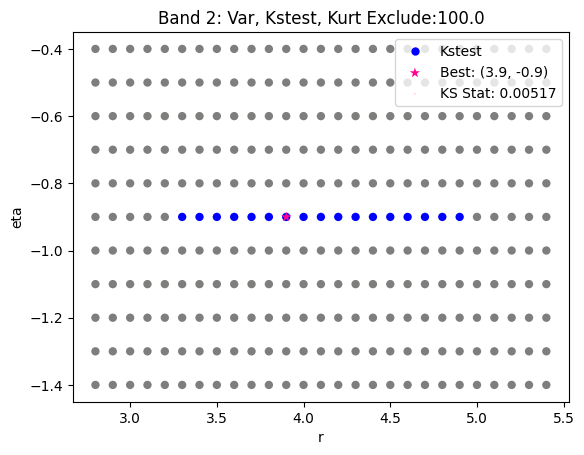

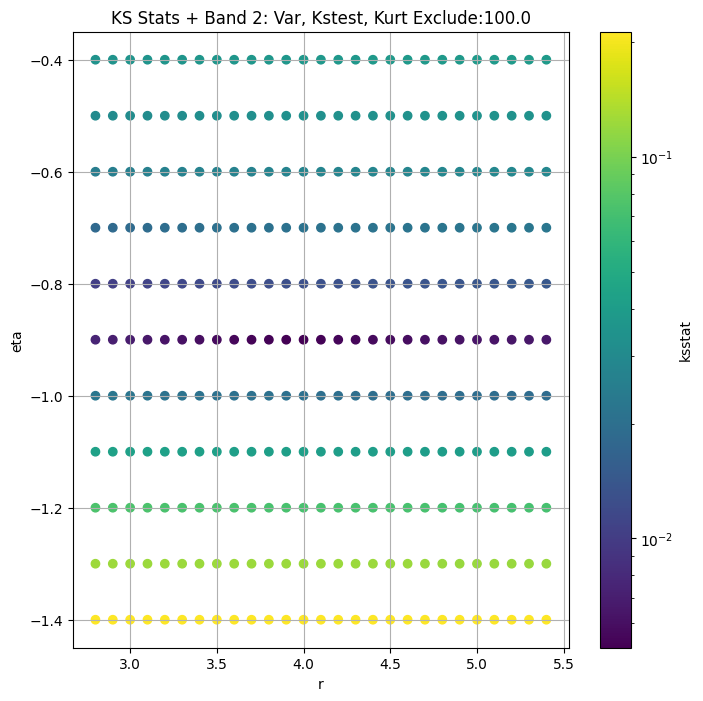

####
Band  5


100%|██████████| 12760/12760 [02:15<00:00, 94.50it/s] 


Finding Minimum after computing 12760 CDFs
5 0 0.008916309901248365 437.0224


100%|██████████| 12760/12760 [02:12<00:00, 96.07it/s] 


Finding Minimum after computing 12760 CDFs
5 25 0.008718407451486554 419.1287


100%|██████████| 12760/12760 [02:15<00:00, 94.24it/s] 


Finding Minimum after computing 12760 CDFs
5 50 0.008000055378976759 409.24817


100%|██████████| 12760/12760 [02:10<00:00, 97.68it/s] 


Finding Minimum after computing 12760 CDFs
5 75 0.007831696958855855 401.4053


100%|██████████| 12760/12760 [02:26<00:00, 86.95it/s] 


Finding Minimum after computing 12760 CDFs
5 100 0.007837058129239516 394.88733


100%|██████████| 12760/12760 [02:32<00:00, 83.91it/s] 


Finding Minimum after computing 12760 CDFs
5 150 0.007836928740776405 383.70978


100%|██████████| 12760/12760 [02:29<00:00, 85.52it/s] 


Finding Minimum after computing 12760 CDFs
5 200 0.007833518222913671 374.22925


100%|██████████| 12760/12760 [02:36<00:00, 81.44it/s] 


Finding Minimum after computing 12760 CDFs
5 250 0.007822208239957273 365.88092


100%|██████████| 12760/12760 [02:31<00:00, 84.08it/s] 


Finding Minimum after computing 12760 CDFs
5 300 0.007803873069626155 358.4269


100%|██████████| 12760/12760 [02:34<00:00, 82.58it/s] 


Finding Minimum after computing 12760 CDFs
5 350 0.007780150208108572 351.72287


100%|██████████| 12760/12760 [01:51<00:00, 114.32it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.0078459874939526 334.29462
Number of samples: 100000, Without approximation : 102030.0


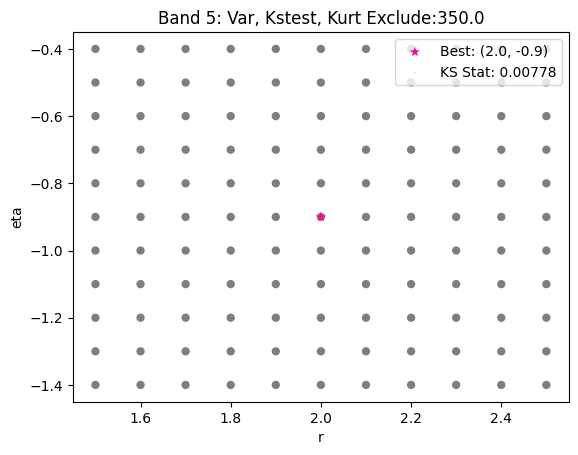

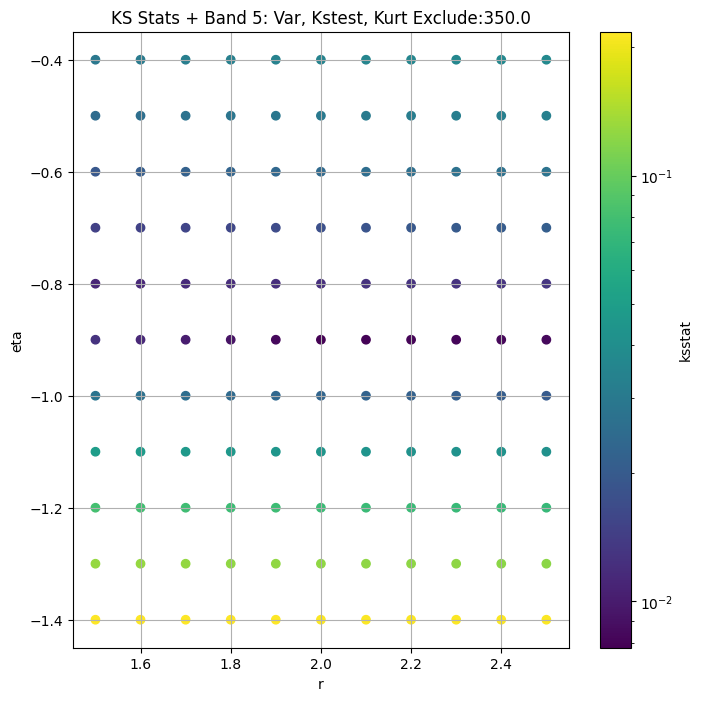

####
Band  8


100%|██████████| 12760/12760 [01:41<00:00, 125.21it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.009007922036999405 126.23157


100%|██████████| 12760/12760 [01:41<00:00, 125.31it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.007869577962298868 120.72284


100%|██████████| 12760/12760 [01:41<00:00, 125.83it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.007113704916059782 117.81839


100%|██████████| 12760/12760 [01:41<00:00, 126.12it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.006559187751901008 115.50845


100%|██████████| 12760/12760 [01:44<00:00, 122.34it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.006633011034638037 113.52564


100%|██████████| 12760/12760 [01:46<00:00, 120.29it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.0069636161724497825 110.20786


100%|██████████| 12760/12760 [01:45<00:00, 120.87it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.006535440210029386 107.39152


100%|██████████| 12760/12760 [01:44<00:00, 122.44it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.006045380251155308 104.93446


100%|██████████| 12760/12760 [01:44<00:00, 122.59it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.006058265225809656 102.71597


100%|██████████| 12760/12760 [01:43<00:00, 123.77it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.006101044849664894 100.69159


100%|██████████| 12760/12760 [01:42<00:00, 124.61it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.007526074576321595 95.43998
Number of samples: 100000, Without approximation : 326496.0


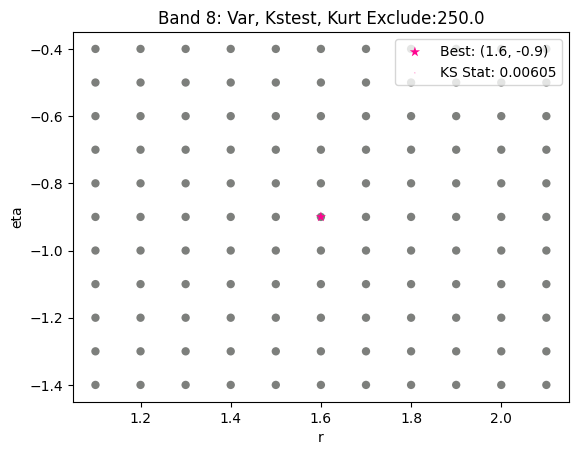

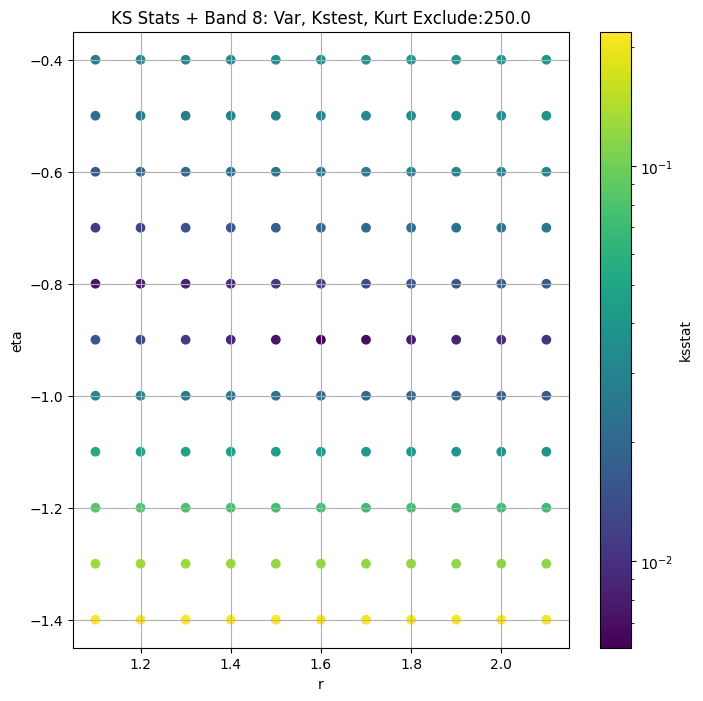

####
Band  11


100%|██████████| 12760/12760 [01:42<00:00, 124.19it/s]


Finding Minimum after computing 12760 CDFs
11 0 0.008493823046503785 33.334743


100%|██████████| 12760/12760 [01:41<00:00, 125.22it/s]


Finding Minimum after computing 12760 CDFs
11 25 0.007253285157084011 31.994476


100%|██████████| 12760/12760 [01:41<00:00, 125.52it/s]


Finding Minimum after computing 12760 CDFs
11 50 0.006967275385696081 31.264479


100%|██████████| 12760/12760 [01:44<00:00, 121.75it/s]


Finding Minimum after computing 12760 CDFs
11 75 0.0060718865290873 30.679104


100%|██████████| 12760/12760 [01:43<00:00, 122.74it/s]


Finding Minimum after computing 12760 CDFs
11 100 0.005900280956699588 30.175135


100%|██████████| 12760/12760 [01:48<00:00, 117.76it/s]


Finding Minimum after computing 12760 CDFs
11 150 0.006488943343584741 29.313147


100%|██████████| 12760/12760 [02:24<00:00, 88.53it/s] 


Finding Minimum after computing 12760 CDFs
11 200 0.006210475012308647 28.579906


100%|██████████| 12760/12760 [02:28<00:00, 86.18it/s] 


Finding Minimum after computing 12760 CDFs
11 250 0.005968437706290963 27.933756


100%|██████████| 12760/12760 [02:33<00:00, 83.15it/s] 


Finding Minimum after computing 12760 CDFs
11 300 0.005868101051977104 27.350098


100%|██████████| 12760/12760 [02:35<00:00, 82.00it/s] 


Finding Minimum after computing 12760 CDFs
11 350 0.005930998077859018 26.816727


100%|██████████| 12760/12760 [02:30<00:00, 85.07it/s] 


Finding Minimum after computing 12760 CDFs
11 500 0.0074923942185413095 25.43227
Number of samples: 100000, Without approximation : 904666.0


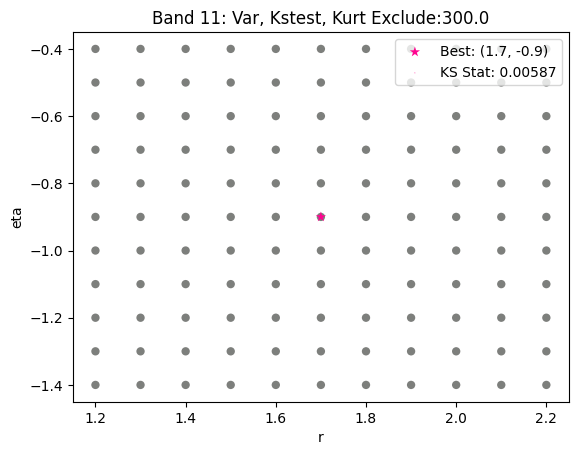

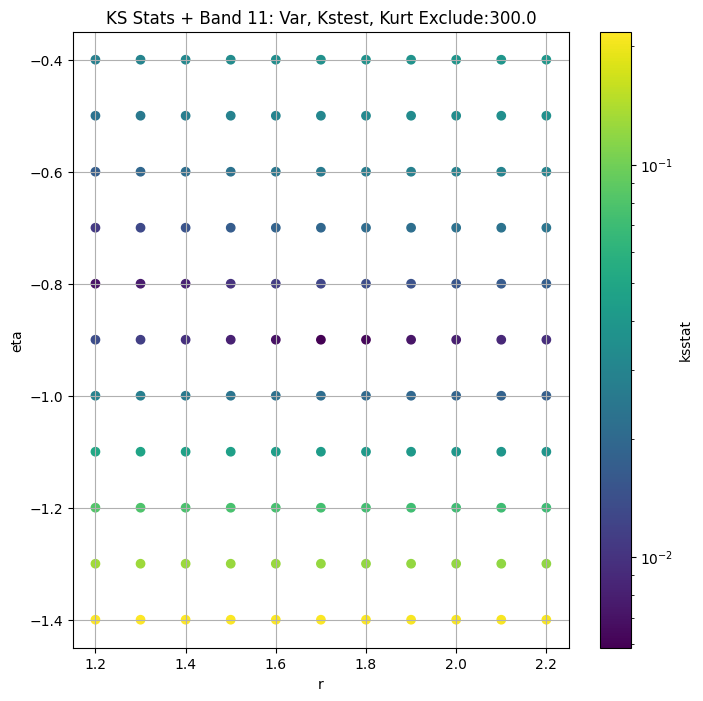

####
Band  14


100%|██████████| 12760/12760 [02:30<00:00, 85.01it/s] 


Finding Minimum after computing 12760 CDFs
14 0 0.007141799719651565 10.371416


100%|██████████| 12760/12760 [02:32<00:00, 83.66it/s] 


Finding Minimum after computing 12760 CDFs
14 25 0.006182122678355051 9.935994


100%|██████████| 12760/12760 [02:19<00:00, 91.65it/s] 


Finding Minimum after computing 12760 CDFs
14 50 0.006528335269017527 9.707553


100%|██████████| 12760/12760 [02:32<00:00, 83.52it/s] 


Finding Minimum after computing 12760 CDFs
14 75 0.006563903011163608 9.52234


100%|██████████| 12760/12760 [02:14<00:00, 94.88it/s] 


Finding Minimum after computing 12760 CDFs
14 100 0.00523817773674784 9.361871


100%|██████████| 12760/12760 [02:12<00:00, 96.12it/s] 


Finding Minimum after computing 12760 CDFs
14 150 0.006340561522451993 9.087693


100%|██████████| 12760/12760 [02:18<00:00, 92.19it/s] 


Finding Minimum after computing 12760 CDFs
14 200 0.005885829399645215 8.854065


100%|██████████| 12760/12760 [02:29<00:00, 85.34it/s] 


Finding Minimum after computing 12760 CDFs
14 250 0.005581845542368624 8.647529


100%|██████████| 12760/12760 [02:16<00:00, 93.50it/s] 


Finding Minimum after computing 12760 CDFs
14 300 0.0055245421631692215 8.461223


100%|██████████| 12760/12760 [02:33<00:00, 83.11it/s] 


Finding Minimum after computing 12760 CDFs
14 350 0.006090268724458503 8.290799


100%|██████████| 12760/12760 [02:58<00:00, 71.44it/s] 


Finding Minimum after computing 12760 CDFs
14 500 0.007848783985879626 7.847665
Number of samples: 100000, Without approximation : 2727602.0


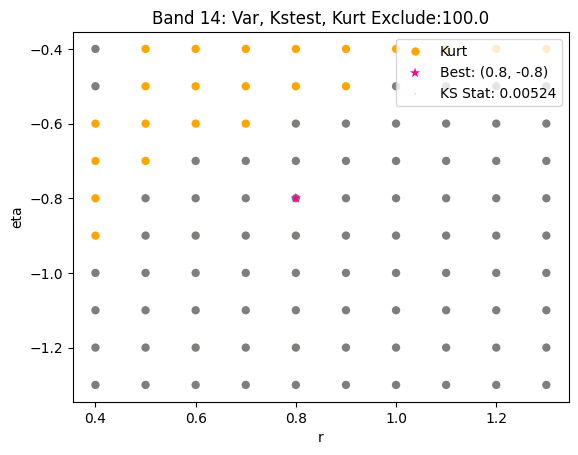

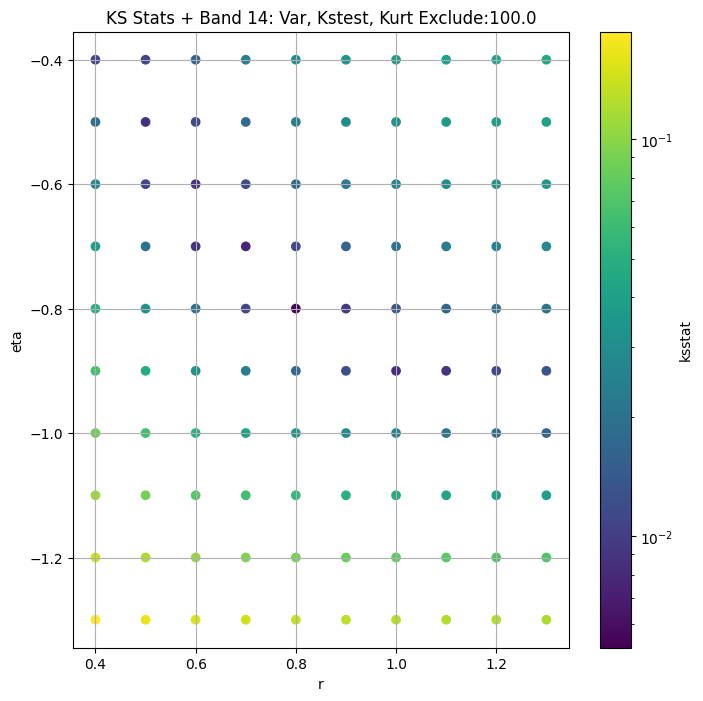

####
Band  17


100%|██████████| 12760/12760 [02:28<00:00, 85.82it/s] 


Finding Minimum after computing 12760 CDFs
17 0 0.004958601006172042 2.5487747


100%|██████████| 12760/12760 [02:35<00:00, 81.91it/s] 


Finding Minimum after computing 12760 CDFs
17 25 0.005572958907830938 2.3909736


100%|██████████| 12760/12760 [02:26<00:00, 86.94it/s] 


Finding Minimum after computing 12760 CDFs
17 50 0.0049567799185922246 2.3307207


100%|██████████| 12760/12760 [02:34<00:00, 82.41it/s] 


Finding Minimum after computing 12760 CDFs
17 75 0.004559428191500237 2.282956


100%|██████████| 12760/12760 [02:34<00:00, 82.48it/s] 


Finding Minimum after computing 12760 CDFs
17 100 0.004225145233052119 2.2420635


100%|██████████| 12760/12760 [02:36<00:00, 81.63it/s] 


Finding Minimum after computing 12760 CDFs
17 150 0.00393439578460808 2.1728492


100%|██████████| 12760/12760 [02:34<00:00, 82.48it/s] 


Finding Minimum after computing 12760 CDFs
17 200 0.004797448681355454 2.114303


100%|██████████| 12760/12760 [02:33<00:00, 83.06it/s] 


Finding Minimum after computing 12760 CDFs
17 250 0.00479876131997381 2.0628393


100%|██████████| 12760/12760 [02:40<00:00, 79.55it/s] 


Finding Minimum after computing 12760 CDFs
17 300 0.0053415194616657224 2.016668


100%|██████████| 12760/12760 [02:41<00:00, 78.95it/s] 


Finding Minimum after computing 12760 CDFs
17 350 0.005936203275031637 1.9745816


100%|██████████| 12760/12760 [02:38<00:00, 80.39it/s] 


Finding Minimum after computing 12760 CDFs
17 500 0.007674551137202501 1.8657557
Number of samples: 100000, Without approximation : 8298440.0


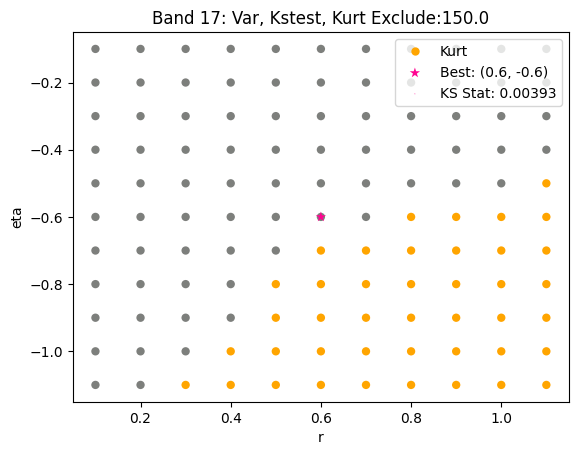

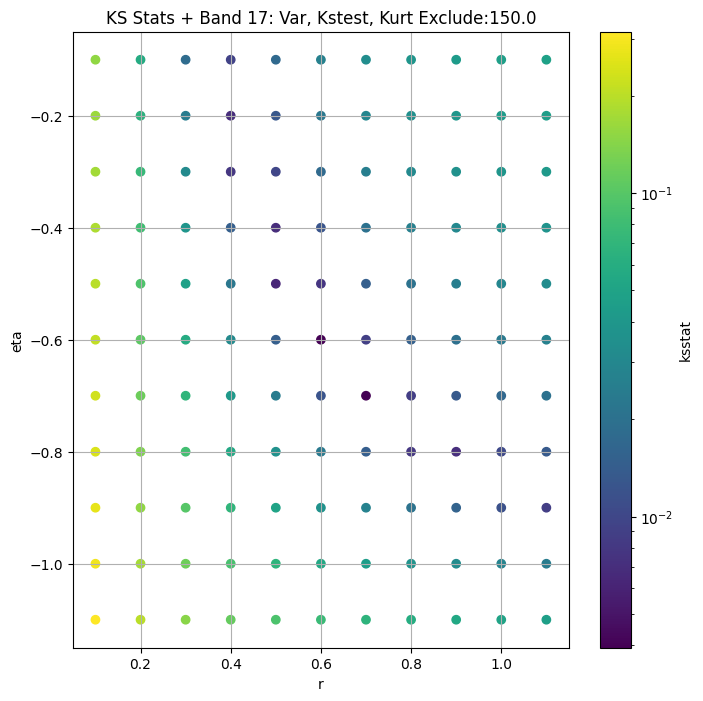

####
Band  20


100%|██████████| 12760/12760 [02:33<00:00, 83.13it/s] 


Finding Minimum after computing 12760 CDFs
20 0 0.0031029195810800686 0.429869


100%|██████████| 12760/12760 [02:26<00:00, 87.06it/s] 


Finding Minimum after computing 12760 CDFs
20 25 0.0019297936930127157 0.37870646


100%|██████████| 12760/12760 [02:27<00:00, 86.54it/s] 


Finding Minimum after computing 12760 CDFs
20 50 0.0020246198258139225 0.36871457


100%|██████████| 12760/12760 [02:29<00:00, 85.20it/s] 


Finding Minimum after computing 12760 CDFs
20 75 0.0022475952388563147 0.36091074


100%|██████████| 12760/12760 [02:30<00:00, 84.54it/s] 


Finding Minimum after computing 12760 CDFs
20 100 0.002805940063227652 0.35428935


100%|██████████| 12760/12760 [02:27<00:00, 86.45it/s] 


Finding Minimum after computing 12760 CDFs
20 150 0.0035335953851431956 0.34314358


100%|██████████| 12760/12760 [02:38<00:00, 80.42it/s] 


Finding Minimum after computing 12760 CDFs
20 200 0.004072828082985369 0.33377597


100%|██████████| 12760/12760 [02:33<00:00, 83.03it/s] 


Finding Minimum after computing 12760 CDFs
20 250 0.004804794514455035 0.32558453


100%|██████████| 12760/12760 [02:33<00:00, 83.17it/s] 


Finding Minimum after computing 12760 CDFs
20 300 0.005412488657933201 0.31825316


100%|██████████| 12760/12760 [02:24<00:00, 88.44it/s] 


Finding Minimum after computing 12760 CDFs
20 350 0.005980894226808253 0.31158015


100%|██████████| 12760/12760 [02:35<00:00, 81.94it/s] 


Finding Minimum after computing 12760 CDFs
20 500 0.00764834629377531 0.29438645
Number of samples: 100000, Without approximation : 25140192.0


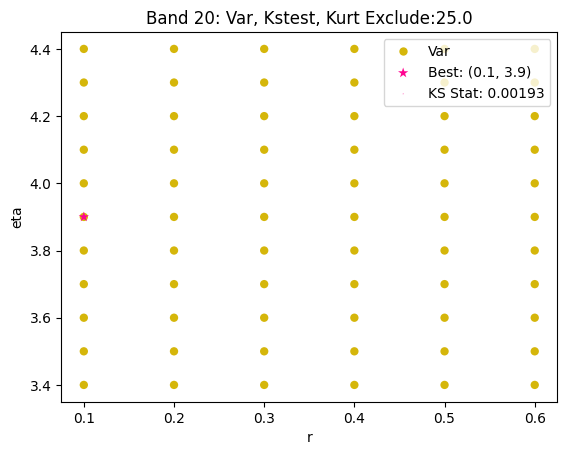

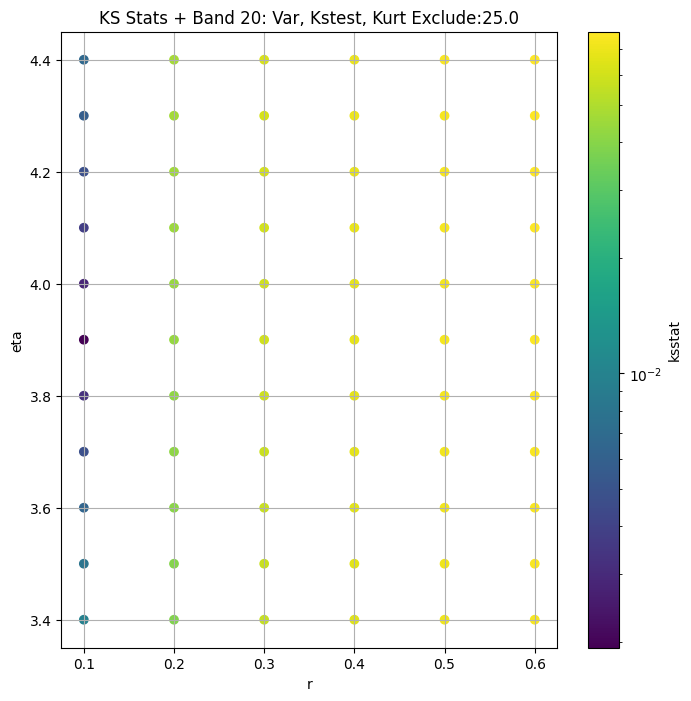

####
Band  23


100%|██████████| 12760/12760 [02:27<00:00, 86.54it/s] 


Finding Minimum after computing 12760 CDFs
23 0 0.0018759426448935468 0.10037543


100%|██████████| 12760/12760 [02:23<00:00, 89.13it/s] 


Finding Minimum after computing 12760 CDFs
23 25 0.0018116194015068698 0.09504277


100%|██████████| 12760/12760 [02:24<00:00, 88.16it/s] 


Finding Minimum after computing 12760 CDFs
23 50 0.0020827823004091472 0.09320135


100%|██████████| 12760/12760 [02:25<00:00, 87.98it/s] 


Finding Minimum after computing 12760 CDFs
23 75 0.0023699931554450604 0.09169521


100%|██████████| 12760/12760 [02:20<00:00, 90.69it/s] 


Finding Minimum after computing 12760 CDFs
23 100 0.002659778662655765 0.09037887


100%|██████████| 12760/12760 [02:24<00:00, 88.19it/s] 


Finding Minimum after computing 12760 CDFs
23 150 0.0033845238702571168 0.088103116


100%|██████████| 12760/12760 [02:36<00:00, 81.44it/s] 


Finding Minimum after computing 12760 CDFs
23 200 0.004047439177956247 0.08614078


100%|██████████| 12760/12760 [02:40<00:00, 79.57it/s] 


Finding Minimum after computing 12760 CDFs
23 250 0.004678518817520239 0.08439269


100%|██████████| 12760/12760 [02:43<00:00, 78.03it/s] 


Finding Minimum after computing 12760 CDFs
23 300 0.0053629622349467 0.08280457


100%|██████████| 12760/12760 [01:58<00:00, 107.47it/s]


Finding Minimum after computing 12760 CDFs
23 350 0.005905007823936437 0.0813421


100%|██████████| 12760/12760 [01:39<00:00, 127.90it/s]


Finding Minimum after computing 12760 CDFs
23 500 0.007565941689028466 0.07750905
Number of samples: 100000, Without approximation : 65734528.0


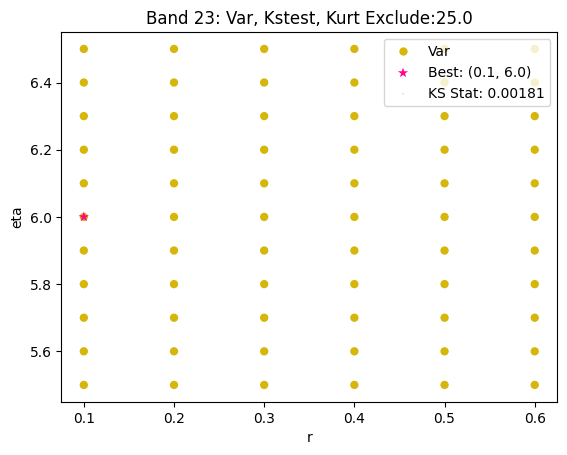

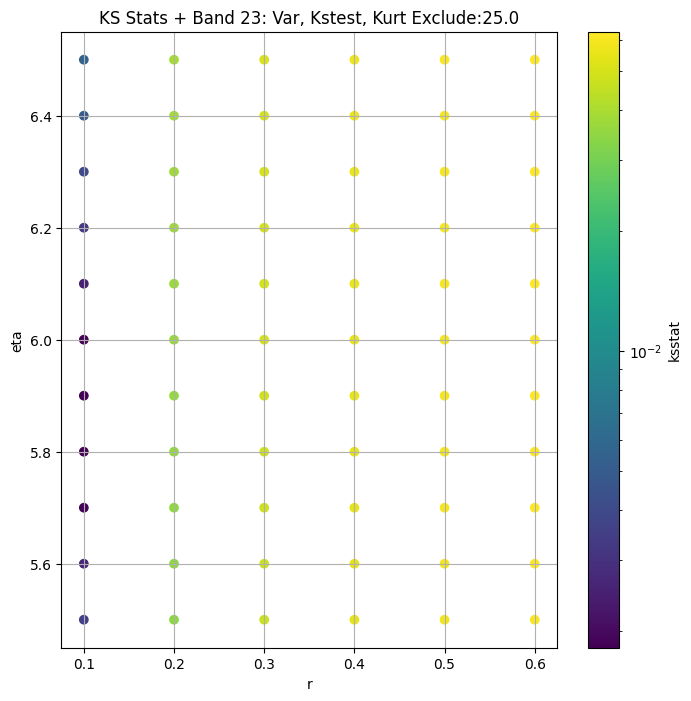

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
band                                                                  
2     1179.389800  1097.971300  1266.585400    5.769592    4.088153   
5      437.022400   401.945200   476.607120    8.911059    5.411635   
8      126.231570   115.505930   139.046250   10.603689    5.844242   
11      33.334743    30.622417    36.353336    9.182022    5.623512   
14      10.371416     9.499190    11.419547   10.649118    5.947791   
17       2.548775     2.287402     3.145427   34.724674    6.520165   
20       0.429869     0.363122     0.795385  315.785900    6.707437   
23       0.100375     0.091152     0.128039   39.690784    4.401588   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                            
2        8.210641        47614.0             0.005172        3.9         -0.9   
5       14.530110       102030.0             0.007780        2.0         -0.9   
8       28.603450       326496.0             0.006045        1.6         -0.9   
11      17.436111       904666.0             0.005868        1.7         -0.9   
14      27.891129      2727602.0             0.005238        0.8         -0.8   
17     200.073500      8298440.0             0.003934        0.6         -0.6   
20    1304.634400     25140192.0             0.001930        0.1          3.9   
23     247.719670     65734528.0             0.001812        0.1          6.0   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      2.902359e+03                   100.0         1035.790600   
5      9.037763e+02                   350.0          351.722870   
8      2.487404e+02                   250.0          104.934460   
11     6.653432e+01                   300.0           27.350098   
14     9.628659e+00                   100.0            9.361871   
17     8.211434e-01                   150.0            2.172849   
20     8.165637e-19                    25.0            0.378706   
23     9.486054e-21                    25.0            0.095043   

      kstest_stat_cutoff_0.05  
band                           
2                    0.006220  
5                    0.004250  
8                    0.002376  
11                   0.001428  
14                   0.000822  
17                   0.000471  
20                   0.000271  
23                   0.000168

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


100%|██████████| 180/180 [00:00<00:00, 289.63it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + 100 = 200, ksstat: 0.006229358956525988, var: 960.3226318359375


100%|██████████| 180/180 [00:00<00:00, 282.69it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + 75 = 175, ksstat: 0.006020642905303464, var: 976.6101684570312


100%|██████████| 180/180 [00:00<00:00, 261.56it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + 50 = 150, ksstat: 0.005723778850919348, var: 994.5272827148438


100%|██████████| 180/180 [00:00<00:00, 273.76it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + 25 = 125, ksstat: 0.005461881116625766, var: 1014.0996704101562


100%|██████████| 180/180 [00:00<00:00, 254.34it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + 0 = 100, ksstat: 0.005172299030336613, var: 1035.7906494140625


100%|██████████| 180/180 [00:00<00:00, 282.51it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + -25 = 75, ksstat: 0.006294291220884443, var: 1059.7486572265625


100%|██████████| 180/180 [00:00<00:00, 253.84it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + -50 = 50, ksstat: 0.0079615468014414, var: 1087.5673828125


100%|██████████| 180/180 [00:00<00:00, 269.23it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + -75 = 25, ksstat: 0.00941168019462224, var: 1122.128173828125


100%|██████████| 180/180 [00:00<00:00, 266.88it/s]


Finding Minimum after computing 180 CDFs
band 2, 100.0 + -100 = 0, ksstat: 0.011942506189680568, var: 1179.3897705078125
Number of samples: 47614, Without approximation : 47614.0


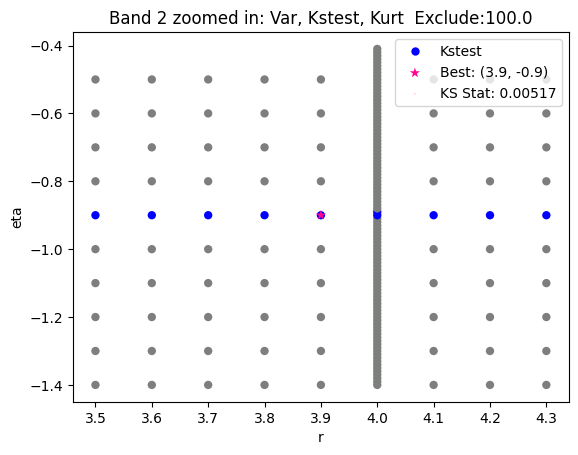

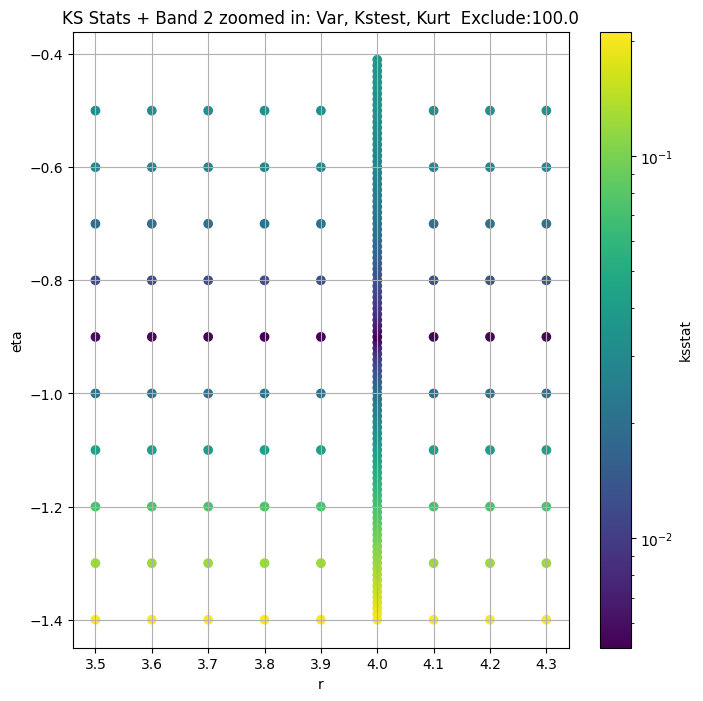

Band 5


100%|██████████| 990/990 [00:08<00:00, 113.35it/s]


Finding Minimum after computing 990 CDFs
band 5, 350.0 + 100 = 450, ksstat: 0.00781710902903976, var: 339.77008056640625


100%|██████████| 990/990 [00:08<00:00, 121.76it/s]


Finding Minimum after computing 990 CDFs
band 5, 350.0 + 75 = 425, ksstat: 0.007788987187160812, var: 342.6197204589844


100%|██████████| 990/990 [00:08<00:00, 122.75it/s]


Finding Minimum after computing 990 CDFs
band 5, 350.0 + 50 = 400, ksstat: 0.007842474045002934, var: 345.5492858886719


100%|██████████| 990/990 [00:07<00:00, 128.85it/s]


Finding Minimum after computing 990 CDFs
band 5, 350.0 + 25 = 375, ksstat: 0.007830214791432477, var: 348.57440185546875


100%|██████████| 990/990 [00:07<00:00, 131.98it/s]


Finding Minimum after computing 990 CDFs
band 5, 350.0 + 0 = 350, ksstat: 0.007751413492863624, var: 351.7228698730469


100%|██████████| 990/990 [00:07<00:00, 129.92it/s]


Finding Minimum after computing 990 CDFs
band 5, 350.0 + -25 = 325, ksstat: 0.0077469138958167205, var: 355.0091247558594


100%|██████████| 990/990 [00:07<00:00, 128.31it/s]


Finding Minimum after computing 990 CDFs
band 5, 350.0 + -50 = 300, ksstat: 0.007732333200488828, var: 358.4269104003906


100%|██████████| 990/990 [00:07<00:00, 128.63it/s]


Finding Minimum after computing 990 CDFs
band 5, 350.0 + -75 = 275, ksstat: 0.007546396977898828, var: 362.04693603515625


100%|██████████| 990/990 [00:07<00:00, 126.20it/s]


Finding Minimum after computing 990 CDFs
band 5, 350.0 + -100 = 250, ksstat: 0.007616335217800252, var: 365.88092041015625
Number of samples: 100000, Without approximation : 102030.0


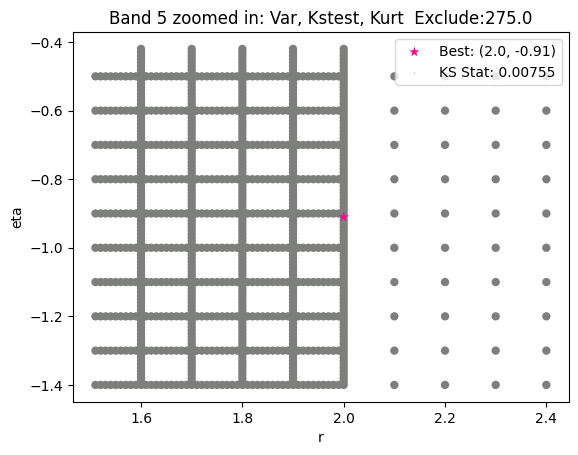

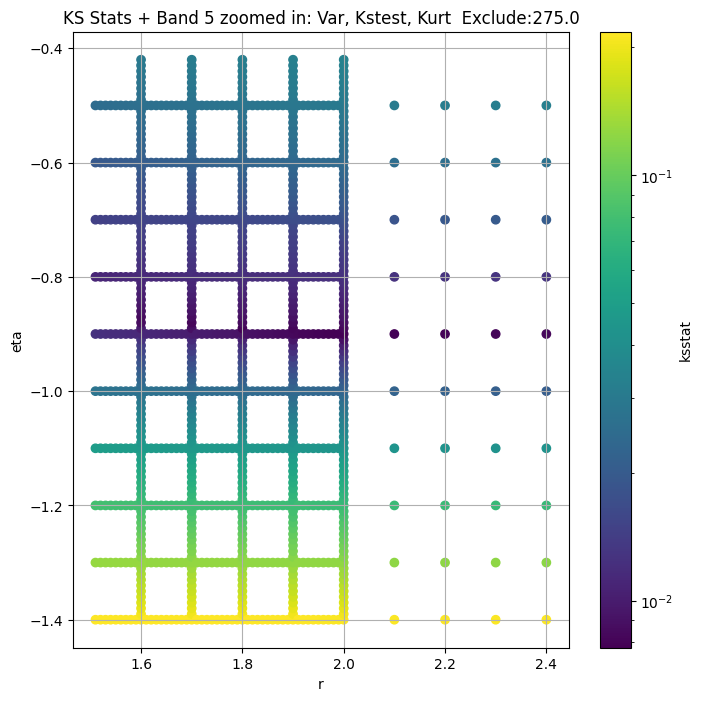

Band 8


100%|██████████| 1710/1710 [00:13<00:00, 123.33it/s]


Finding Minimum after computing 1710 CDFs
band 8, 250.0 + 100 = 350, ksstat: 0.005944329936446113, var: 100.69158935546875


100%|██████████| 1710/1710 [00:13<00:00, 125.82it/s]


Finding Minimum after computing 1710 CDFs
band 8, 250.0 + 75 = 325, ksstat: 0.005657674957912917, var: 101.68340301513672


100%|██████████| 1710/1710 [00:13<00:00, 125.62it/s]


Finding Minimum after computing 1710 CDFs
band 8, 250.0 + 50 = 300, ksstat: 0.0054825285460176065, var: 102.71597290039062


100%|██████████| 1710/1710 [00:13<00:00, 129.30it/s]


Finding Minimum after computing 1710 CDFs
band 8, 250.0 + 25 = 275, ksstat: 0.005457855270250611, var: 103.79840087890625


100%|██████████| 1710/1710 [00:13<00:00, 127.13it/s]


Finding Minimum after computing 1710 CDFs
band 8, 250.0 + 0 = 250, ksstat: 0.00555631659390865, var: 104.93446350097656


100%|██████████| 1710/1710 [00:13<00:00, 128.56it/s]


Finding Minimum after computing 1710 CDFs
band 8, 250.0 + -25 = 225, ksstat: 0.005745785536467762, var: 106.12600708007812


100%|██████████| 1710/1710 [00:13<00:00, 129.38it/s]


Finding Minimum after computing 1710 CDFs
band 8, 250.0 + -50 = 200, ksstat: 0.005704124286500689, var: 107.39151763916016


100%|██████████| 1710/1710 [00:13<00:00, 127.03it/s]


Finding Minimum after computing 1710 CDFs
band 8, 250.0 + -75 = 175, ksstat: 0.005980549513998734, var: 108.74528503417969


100%|██████████| 1710/1710 [00:13<00:00, 127.35it/s]


Finding Minimum after computing 1710 CDFs
band 8, 250.0 + -100 = 150, ksstat: 0.006211639497682331, var: 110.2078628540039
Number of samples: 100000, Without approximation : 326496.0


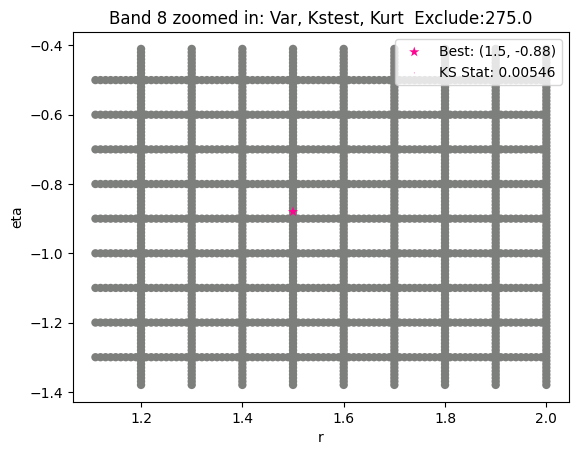

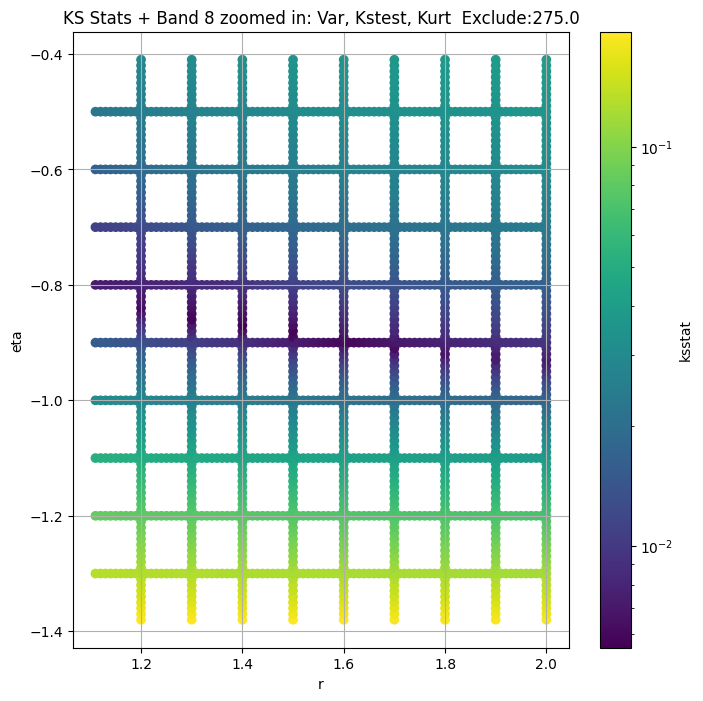

Band 11


100%|██████████| 1530/1530 [00:12<00:00, 127.46it/s]


Finding Minimum after computing 1530 CDFs
band 11, 300.0 + 100 = 400, ksstat: 0.006306383089647816, var: 26.323505401611328


100%|██████████| 1530/1530 [00:12<00:00, 126.98it/s]


Finding Minimum after computing 1530 CDFs
band 11, 300.0 + 75 = 375, ksstat: 0.006006937126192158, var: 26.565448760986328


100%|██████████| 1530/1530 [00:12<00:00, 124.71it/s]


Finding Minimum after computing 1530 CDFs
band 11, 300.0 + 50 = 350, ksstat: 0.005739378314109533, var: 26.816726684570312


100%|██████████| 1530/1530 [00:11<00:00, 129.37it/s]


Finding Minimum after computing 1530 CDFs
band 11, 300.0 + 25 = 325, ksstat: 0.005473816902331952, var: 27.077831268310547


100%|██████████| 1530/1530 [00:11<00:00, 132.43it/s]


Finding Minimum after computing 1530 CDFs
band 11, 300.0 + 0 = 300, ksstat: 0.005300113187533206, var: 27.35009765625


100%|██████████| 1530/1530 [00:11<00:00, 130.45it/s]


Finding Minimum after computing 1530 CDFs
band 11, 300.0 + -25 = 275, ksstat: 0.0051271161080572725, var: 27.635000228881836


100%|██████████| 1530/1530 [00:11<00:00, 130.16it/s]


Finding Minimum after computing 1530 CDFs
band 11, 300.0 + -50 = 250, ksstat: 0.0051710983536682464, var: 27.93375587463379


100%|██████████| 1530/1530 [00:11<00:00, 132.93it/s]


Finding Minimum after computing 1530 CDFs
band 11, 300.0 + -75 = 225, ksstat: 0.0053005351403746515, var: 28.247995376586914


100%|██████████| 1530/1530 [00:11<00:00, 128.21it/s]


Finding Minimum after computing 1530 CDFs
band 11, 300.0 + -100 = 200, ksstat: 0.0054813655941634565, var: 28.579906463623047
Number of samples: 100000, Without approximation : 904666.0


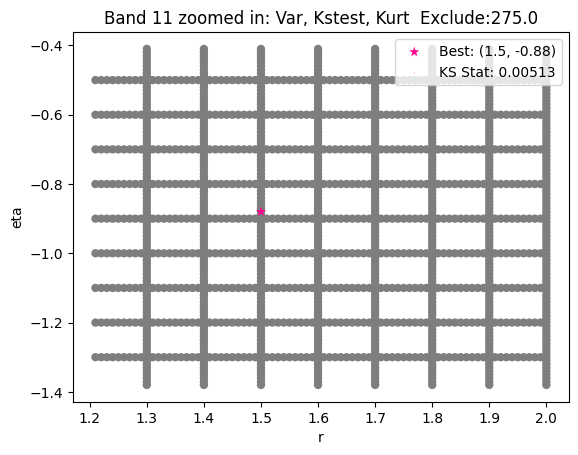

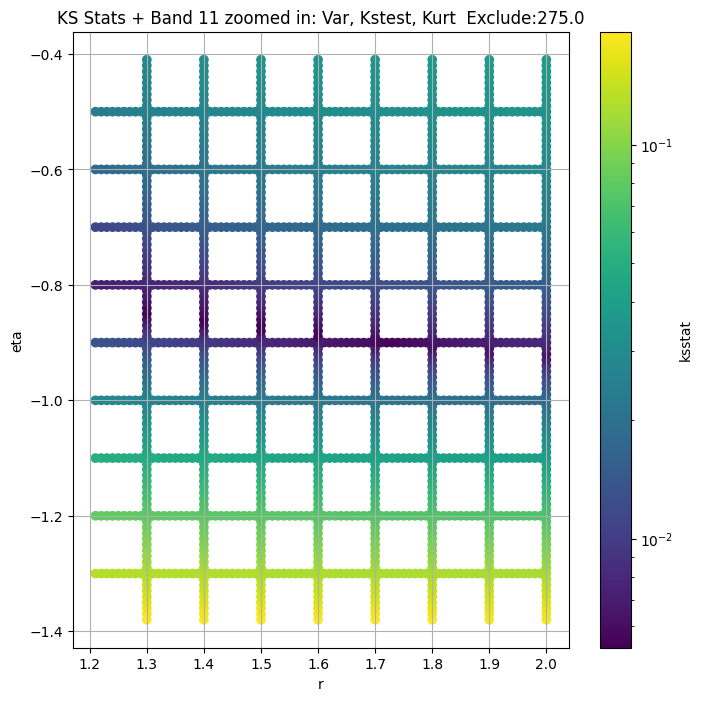

Band 14


100%|██████████| 1701/1701 [00:13<00:00, 127.08it/s]


Finding Minimum after computing 1701 CDFs
band 14, 100.0 + 100 = 200, ksstat: 0.005065166847564556, var: 8.85406494140625


100%|██████████| 1701/1701 [00:13<00:00, 126.90it/s]


Finding Minimum after computing 1701 CDFs
band 14, 100.0 + 75 = 175, ksstat: 0.005088128369081235, var: 8.966937065124512


100%|██████████| 1701/1701 [00:13<00:00, 126.25it/s]


Finding Minimum after computing 1701 CDFs
band 14, 100.0 + 50 = 150, ksstat: 0.005082352597205131, var: 9.087693214416504


100%|██████████| 1701/1701 [00:13<00:00, 125.09it/s]


Finding Minimum after computing 1701 CDFs
band 14, 100.0 + 25 = 125, ksstat: 0.0051916509445926184, var: 9.218487739562988


100%|██████████| 1701/1701 [00:13<00:00, 125.27it/s]


Finding Minimum after computing 1701 CDFs
band 14, 100.0 + 0 = 100, ksstat: 0.005235178613018698, var: 9.361870765686035


100%|██████████| 1701/1701 [00:13<00:00, 125.32it/s]


Finding Minimum after computing 1701 CDFs
band 14, 100.0 + -25 = 75, ksstat: 0.005434751130294235, var: 9.522339820861816


100%|██████████| 1701/1701 [00:13<00:00, 125.05it/s]


Finding Minimum after computing 1701 CDFs
band 14, 100.0 + -50 = 50, ksstat: 0.0055506145691888165, var: 9.707552909851074


100%|██████████| 1701/1701 [00:13<00:00, 124.40it/s]


Finding Minimum after computing 1701 CDFs
band 14, 100.0 + -75 = 25, ksstat: 0.006104565431209408, var: 9.935994148254395


100%|██████████| 1701/1701 [00:13<00:00, 127.54it/s]


Finding Minimum after computing 1701 CDFs
band 14, 100.0 + -100 = 0, ksstat: 0.005899968344027395, var: 10.371416091918945
Number of samples: 100000, Without approximation : 2727602.0


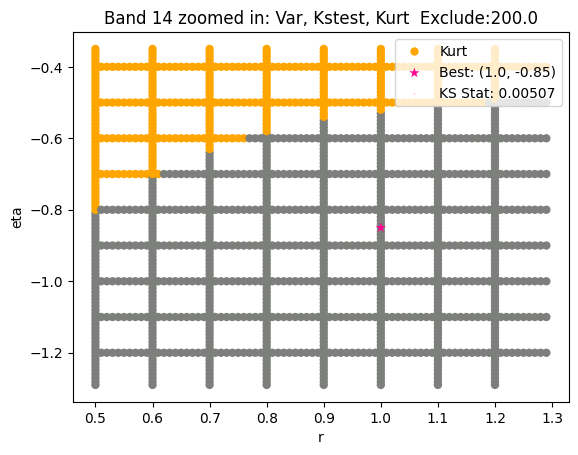

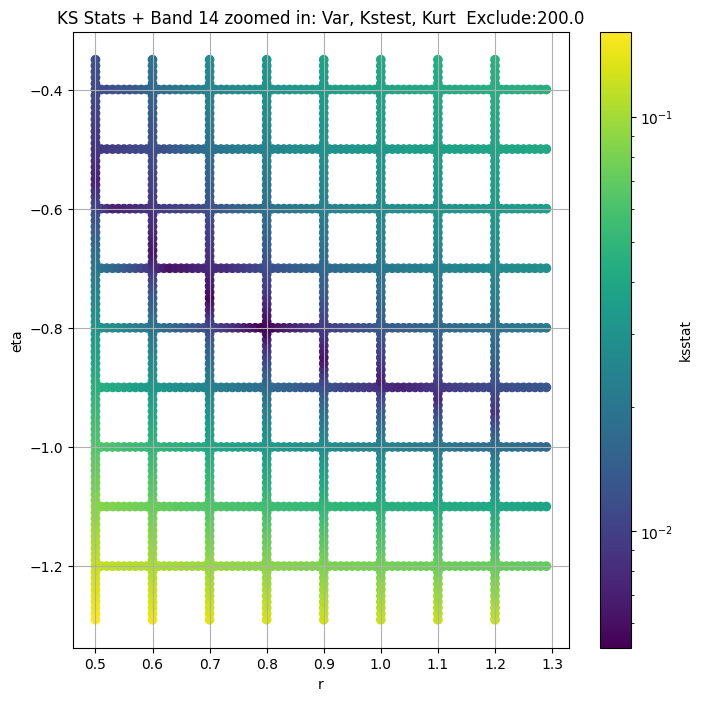

Band 17


100%|██████████| 1701/1701 [00:13<00:00, 124.52it/s]


Finding Minimum after computing 1701 CDFs
band 17, 150.0 + 100 = 250, ksstat: 0.004619529608725026, var: 2.0628392696380615


100%|██████████| 1701/1701 [00:13<00:00, 122.57it/s]


Finding Minimum after computing 1701 CDFs
band 17, 150.0 + 75 = 225, ksstat: 0.004296419714272193, var: 2.0878100395202637


100%|██████████| 1701/1701 [00:13<00:00, 123.43it/s]


Finding Minimum after computing 1701 CDFs
band 17, 150.0 + 50 = 200, ksstat: 0.003971171894606607, var: 2.1143031120300293


100%|██████████| 1701/1701 [00:13<00:00, 121.59it/s]


Finding Minimum after computing 1701 CDFs
band 17, 150.0 + 25 = 175, ksstat: 0.0035972122527738737, var: 2.14253830909729


100%|██████████| 1701/1701 [00:13<00:00, 127.61it/s]


Finding Minimum after computing 1701 CDFs
band 17, 150.0 + 0 = 150, ksstat: 0.00393439578460808, var: 2.172849178314209


100%|██████████| 1701/1701 [00:13<00:00, 125.67it/s]


Finding Minimum after computing 1701 CDFs
band 17, 150.0 + -25 = 125, ksstat: 0.003814329208986722, var: 2.205749273300171


100%|██████████| 1701/1701 [00:13<00:00, 129.65it/s]


Finding Minimum after computing 1701 CDFs
band 17, 150.0 + -50 = 100, ksstat: 0.0037281943010636365, var: 2.242063522338867


100%|██████████| 1701/1701 [00:12<00:00, 131.64it/s]


Finding Minimum after computing 1701 CDFs
band 17, 150.0 + -75 = 75, ksstat: 0.003973421143356026, var: 2.2829558849334717


100%|██████████| 1701/1701 [00:13<00:00, 126.60it/s]


Finding Minimum after computing 1701 CDFs
band 17, 150.0 + -100 = 50, ksstat: 0.0039596997613389195, var: 2.3307206630706787
Number of samples: 100000, Without approximation : 8298440.0


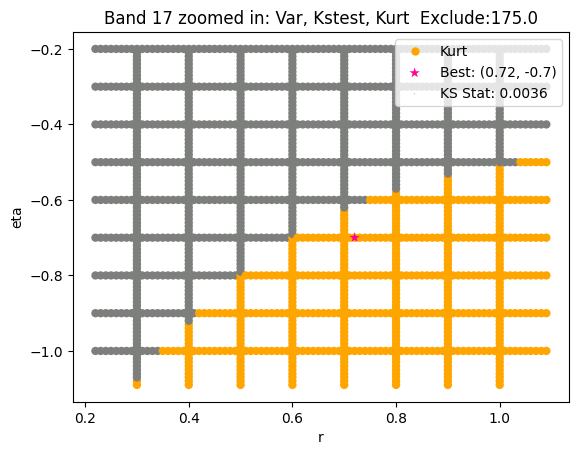

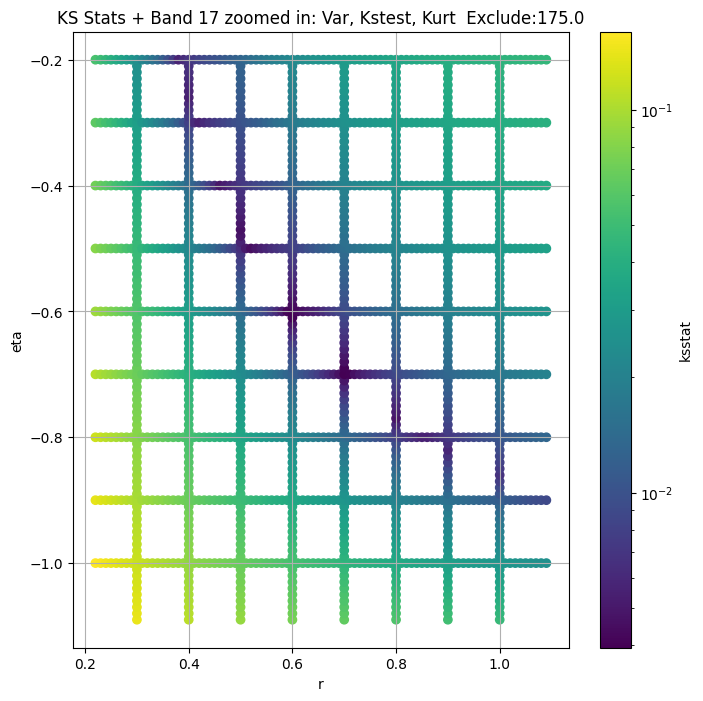

Band 20


100%|██████████| 522/522 [00:04<00:00, 126.74it/s]


Finding Minimum after computing 522 CDFs
band 20, 25.0 + 100 = 125, ksstat: 0.004337807625523271, var: 0.3484360873699188


100%|██████████| 522/522 [00:04<00:00, 129.47it/s]


Finding Minimum after computing 522 CDFs
band 20, 25.0 + 75 = 100, ksstat: 0.003917598814960732, var: 0.35428935289382935


100%|██████████| 522/522 [00:04<00:00, 126.35it/s]


Finding Minimum after computing 522 CDFs
band 20, 25.0 + 50 = 75, ksstat: 0.0033029413922865958, var: 0.3609107434749603


100%|██████████| 522/522 [00:03<00:00, 130.84it/s]


Finding Minimum after computing 522 CDFs
band 20, 25.0 + 25 = 50, ksstat: 0.0026917610484007426, var: 0.3687145709991455


100%|██████████| 522/522 [00:03<00:00, 132.04it/s]


Finding Minimum after computing 522 CDFs
band 20, 25.0 + 0 = 25, ksstat: 0.0019297936930127157, var: 0.3787064552307129


100%|██████████| 522/522 [00:04<00:00, 125.68it/s]


Finding Minimum after computing 522 CDFs
band 20, 25.0 + -25 = 0, ksstat: 0.0032144654466034622, var: 0.42986899614334106
Number of samples: 100000, Without approximation : 25140192.0


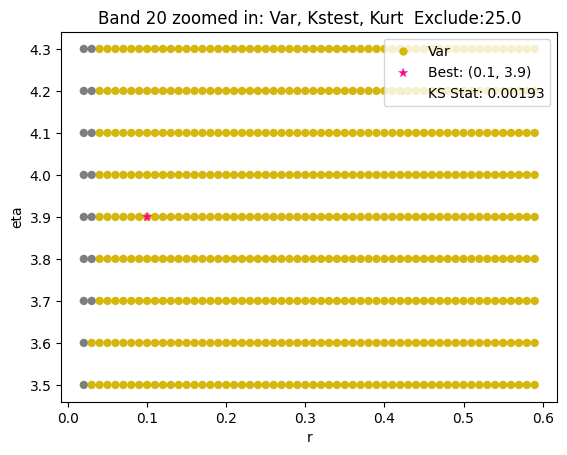

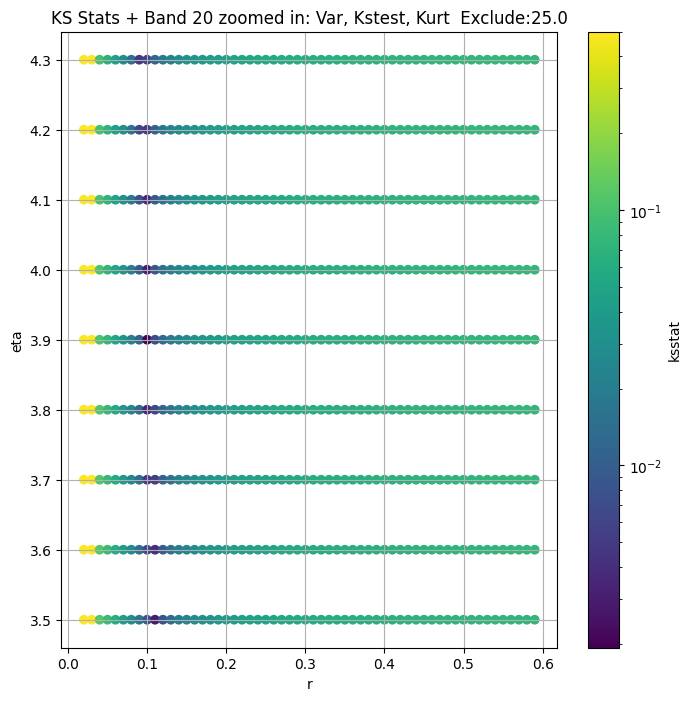

Band 23


100%|██████████| 522/522 [00:04<00:00, 120.91it/s]


Finding Minimum after computing 522 CDFs
band 23, 25.0 + 100 = 125, ksstat: 0.003951529780896856, var: 0.08919243514537811


100%|██████████| 522/522 [00:04<00:00, 124.00it/s]


Finding Minimum after computing 522 CDFs
band 23, 25.0 + 75 = 100, ksstat: 0.003512736047274867, var: 0.09037887305021286


100%|██████████| 522/522 [00:04<00:00, 126.33it/s]


Finding Minimum after computing 522 CDFs
band 23, 25.0 + 50 = 75, ksstat: 0.0029934560225551854, var: 0.09169521182775497


100%|██████████| 522/522 [00:04<00:00, 123.79it/s]


Finding Minimum after computing 522 CDFs
band 23, 25.0 + 25 = 50, ksstat: 0.002471030357164561, var: 0.09320134669542313


100%|██████████| 522/522 [00:04<00:00, 124.07it/s]


Finding Minimum after computing 522 CDFs
band 23, 25.0 + 0 = 25, ksstat: 0.0018116194015068698, var: 0.09504277259111404


100%|██████████| 522/522 [00:04<00:00, 125.25it/s]


Finding Minimum after computing 522 CDFs
band 23, 25.0 + -25 = 0, ksstat: 0.0018257676484706165, var: 0.10037542879581451
Number of samples: 100000, Without approximation : 65734528.0


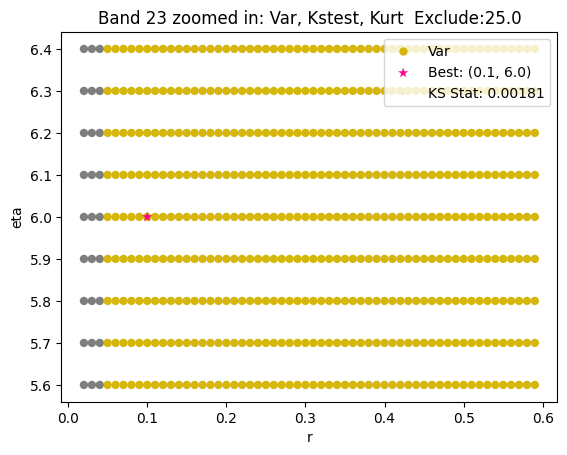

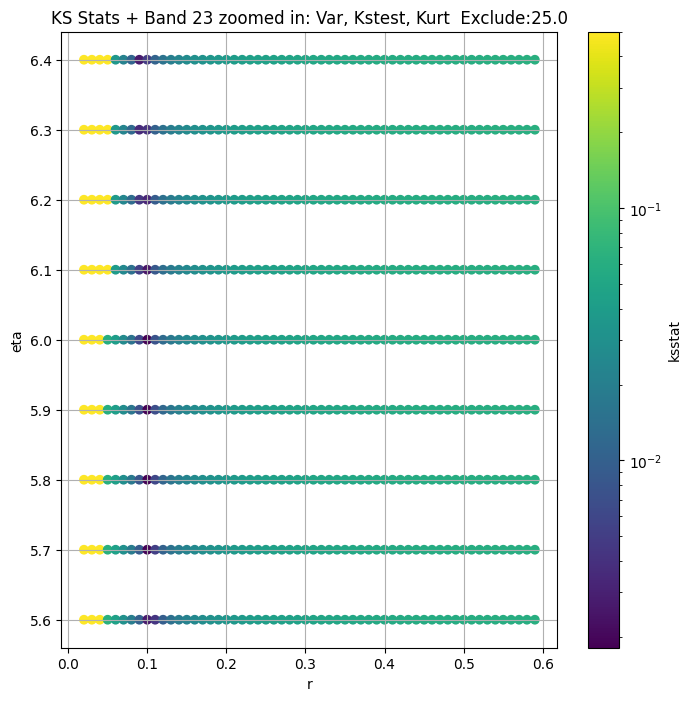

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
band                                                                  
2     1179.389800  1097.971300  1266.585400    5.769592    4.088153   
5      437.022400   401.945200   476.607120    8.911059    5.411635   
8      126.231570   115.505930   139.046250   10.603689    5.844242   
11      33.334743    30.622417    36.353336    9.182022    5.623512   
14      10.371416     9.499190    11.419547   10.649118    5.947791   
17       2.548775     2.287402     3.145427   34.724674    6.520165   
20       0.429869     0.363122     0.795385  315.785900    6.707437   
23       0.100375     0.091152     0.128039   39.690784    4.401588   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                            
2        8.210641        47614.0             0.005172        3.9         -0.9   
5       14.530110       102030.0             0.007780        2.0         -0.9   
8       28.603450       326496.0             0.006045        1.6         -0.9   
11      17.436111       904666.0             0.005868        1.7         -0.9   
14      27.891129      2727602.0             0.005238        0.8         -0.8   
17     200.073500      8298440.0             0.003934        0.6         -0.6   
20    1304.634400     25140192.0             0.001930        0.1          3.9   
23     247.719670     65734528.0             0.001812        0.1          6.0   

      initial_scale  initial_exclude_cutoff  best_augmented_var  \
band                                                              
2      2.902359e+03                   100.0         1035.790600   
5      9.037763e+02                   350.0          362.046936   
8      2.487404e+02                   250.0          103.798401   
11     6.653432e+01                   300.0           27.635000   
14     9.628659e+00                   100.0            8.854065   
17     8.211434e-01                   150.0            2.142538   
20     8.165637e-19                    25.0            0.378706   
23     9.486054e-21                    25.0            0.095043   

      kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
band                                                                
2                    0.006220          0.005172    3.90     -0.90   
5                    0.004250          0.007546    2.00     -0.91   
8                    0.002376          0.005458    1.50     -0.88   
11                   0.001428          0.005127    1.50     -0.88   
14                   0.000822          0.005065    1.00     -0.85   
17                   0.000471          0.003597    0.72     -0.70   
20                   0.000271          0.001930    0.10      3.90   
23                   0.000168          0.001812    0.10      6.00   

        best_scale  best_exclude_cutoff  n_pval_0.05  
band                                                  
2     2.902359e+03                100.0        71421  
5     9.423018e+02                275.0        32281  
8     2.319957e+02                275.0        61218  
11    6.176591e+01                275.0        71557  
14    1.362164e+01                200.0        71917  
17    1.526253e+00                175.0       145870  
20    8.165637e-19                 25.0       497155  
23    9.486054e-21                 25.0       577744

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

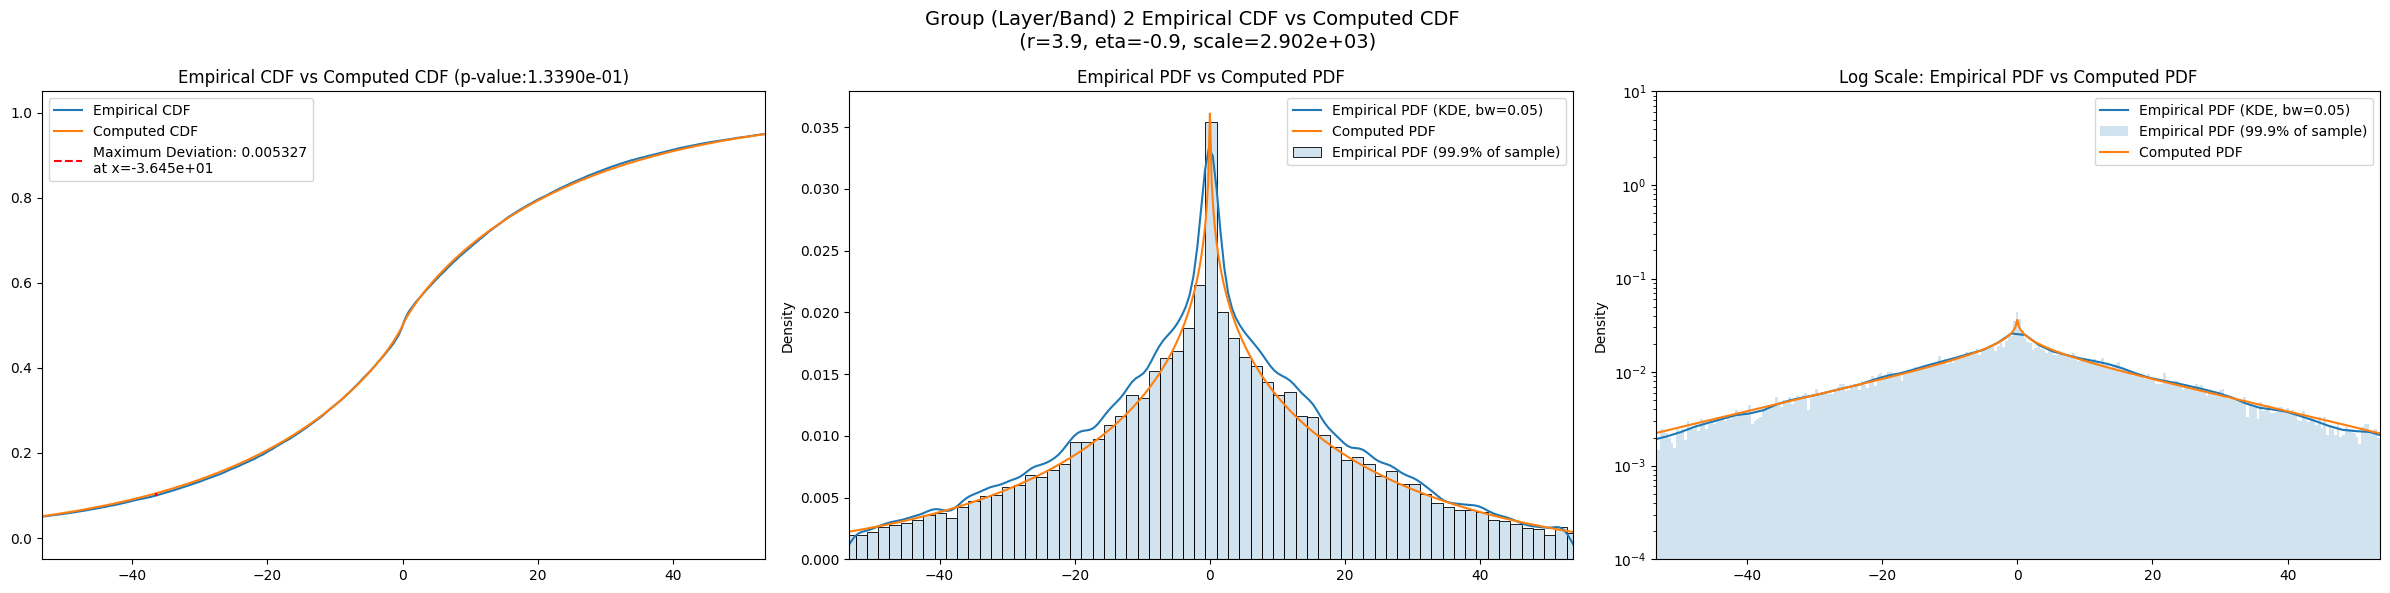

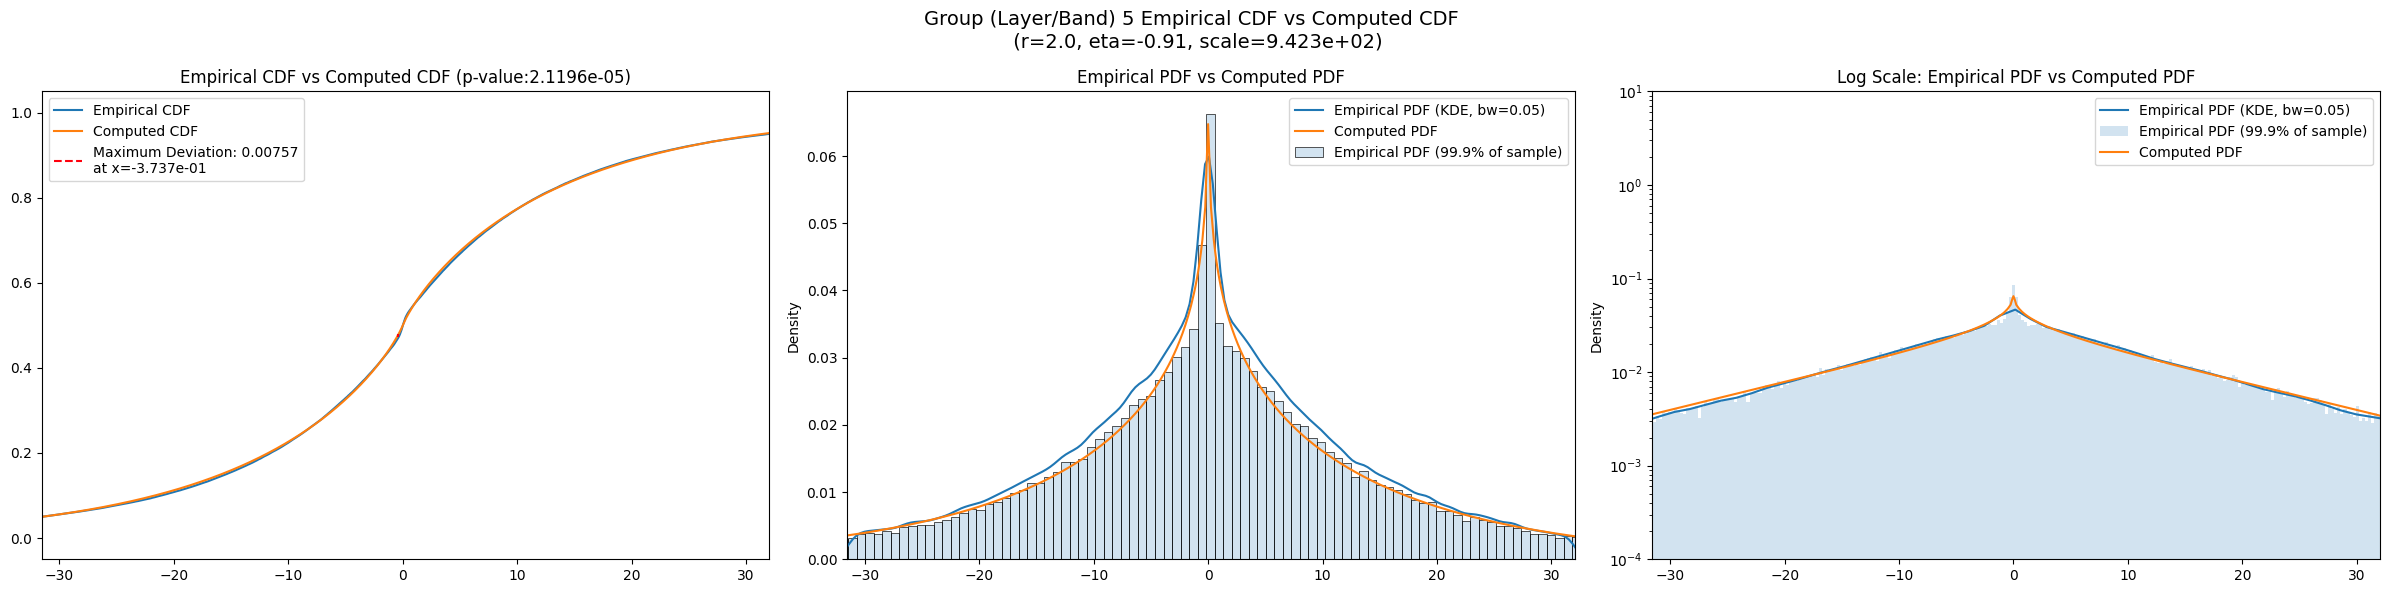

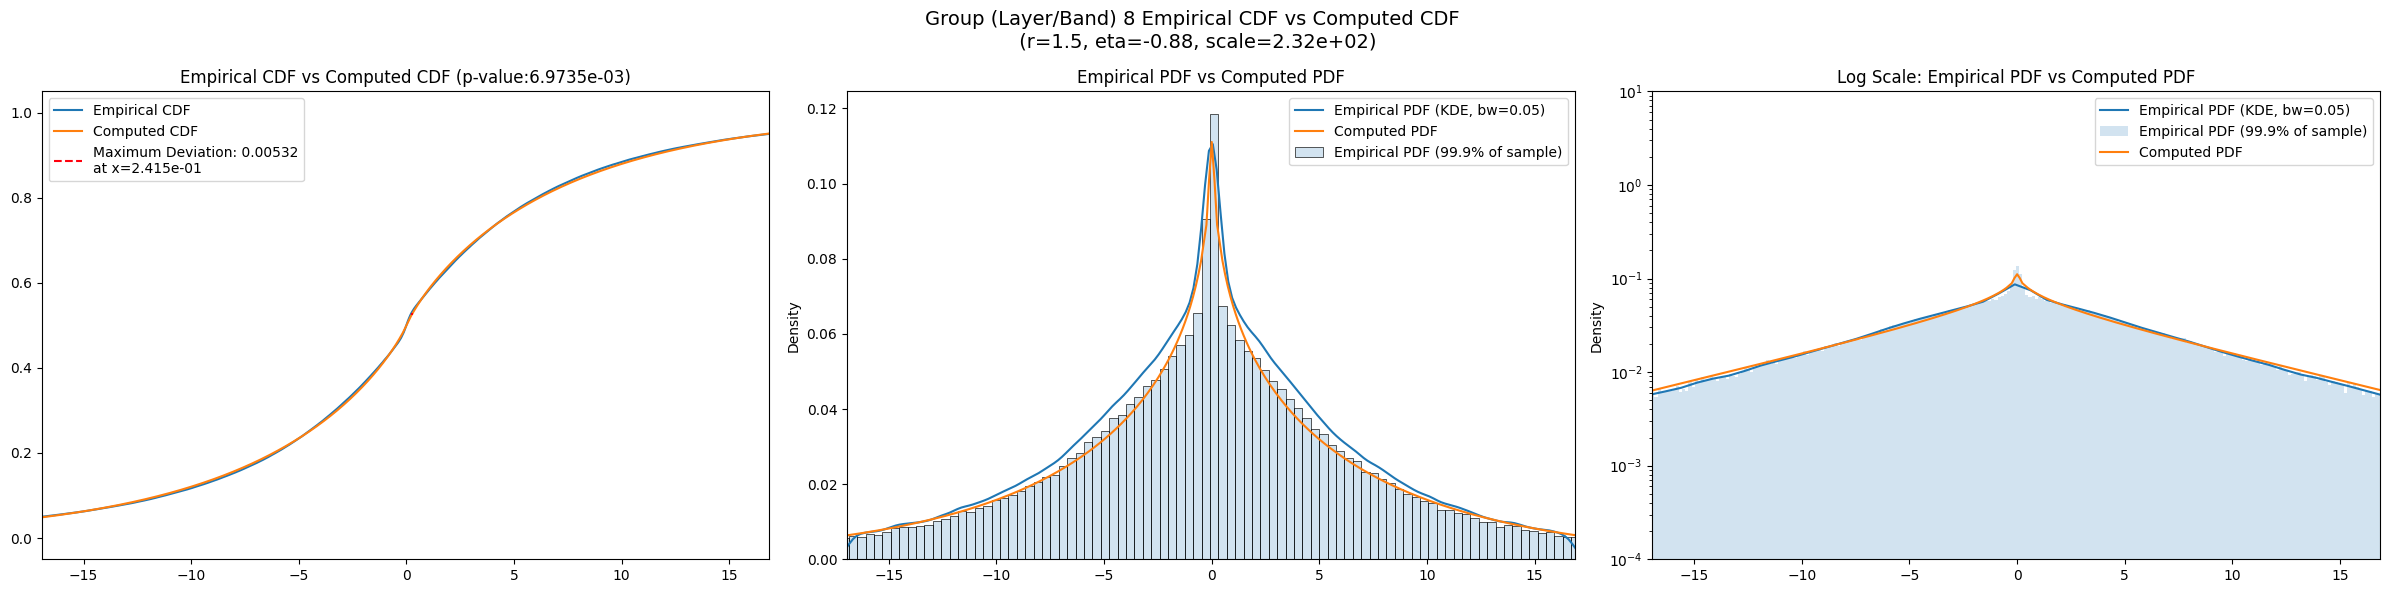

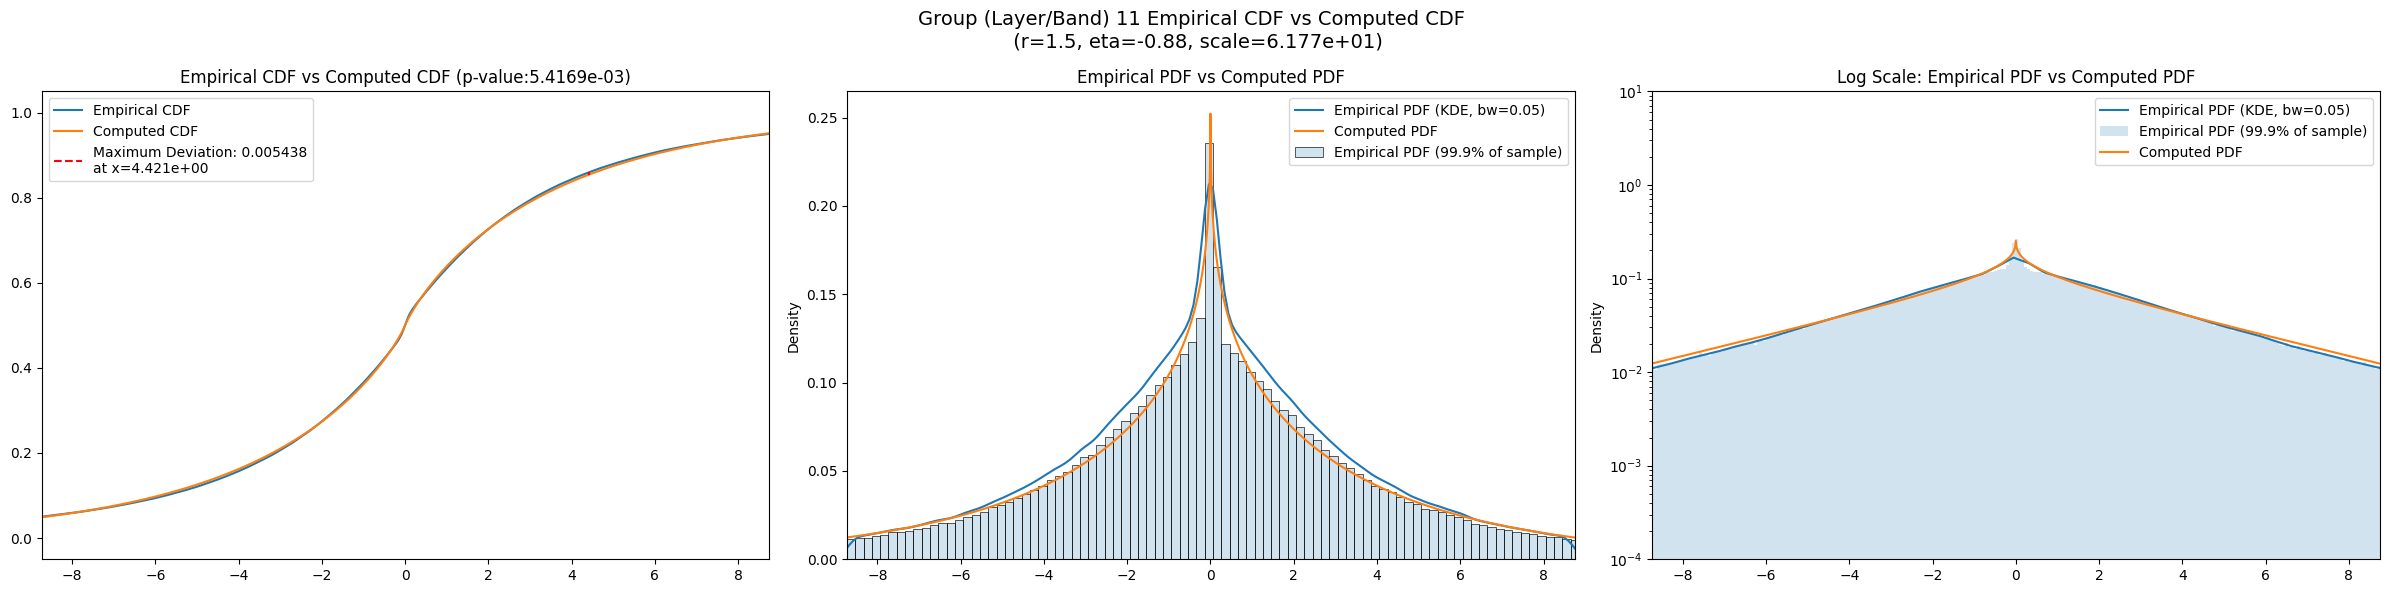

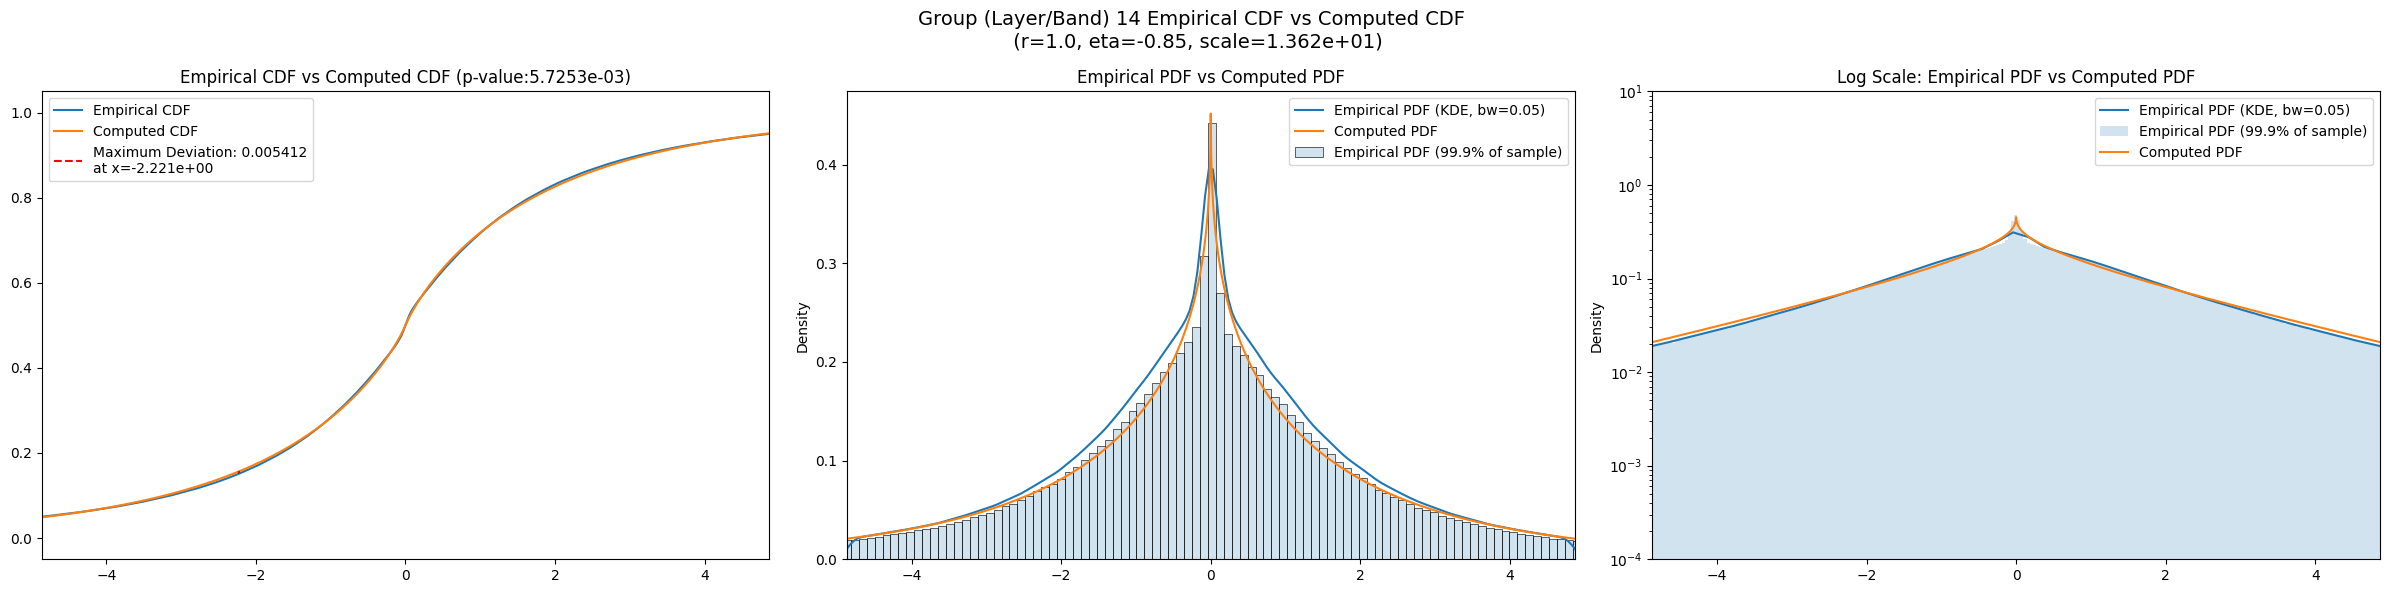

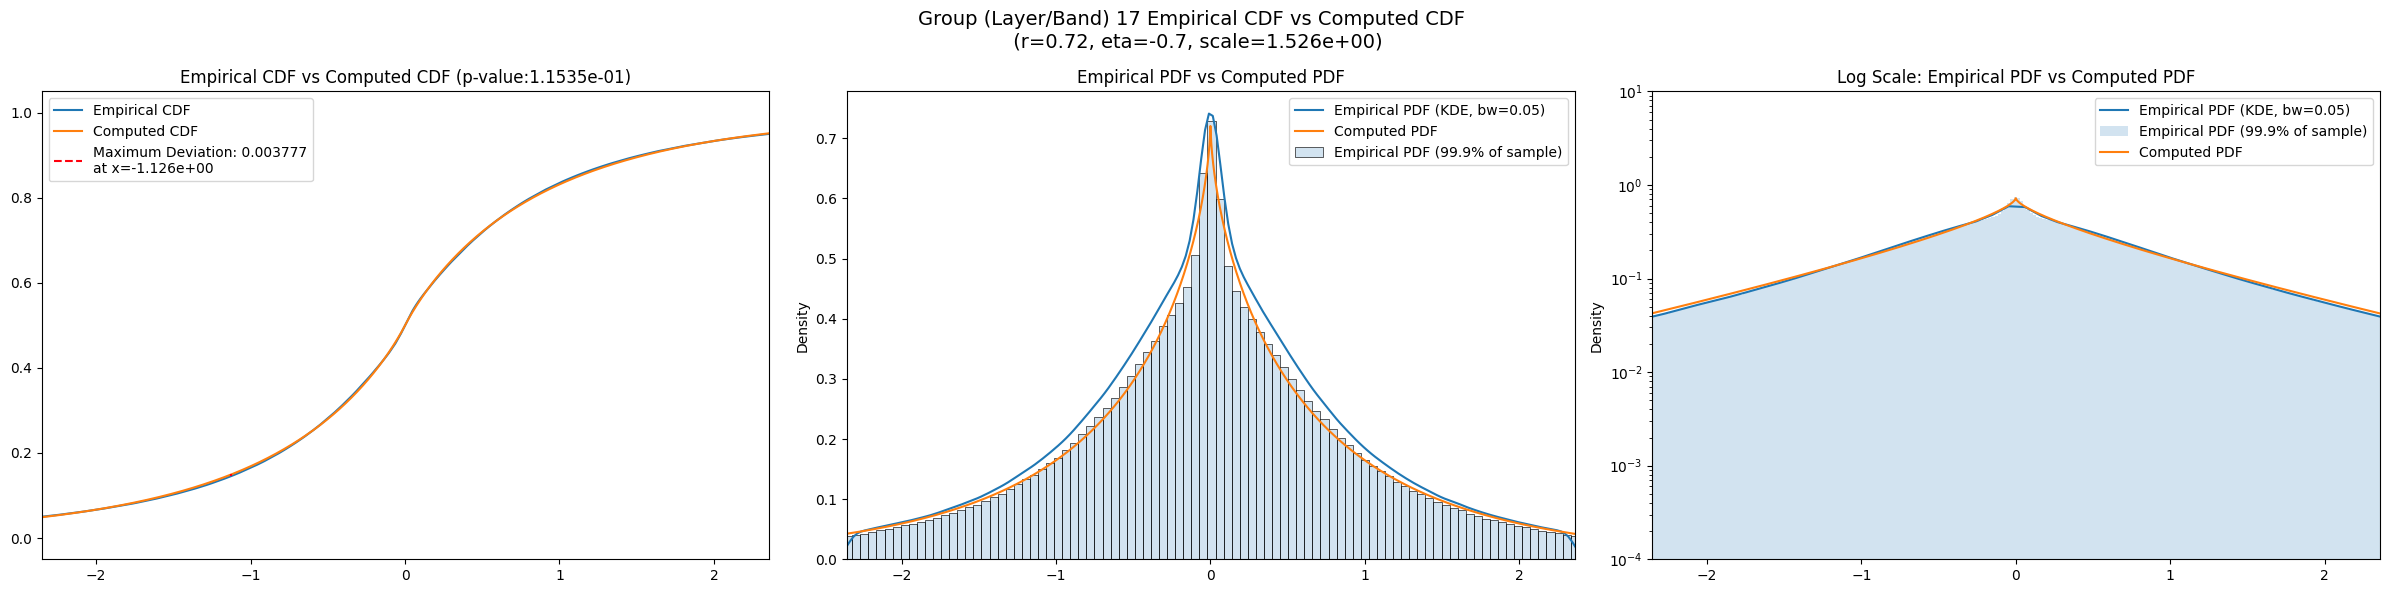

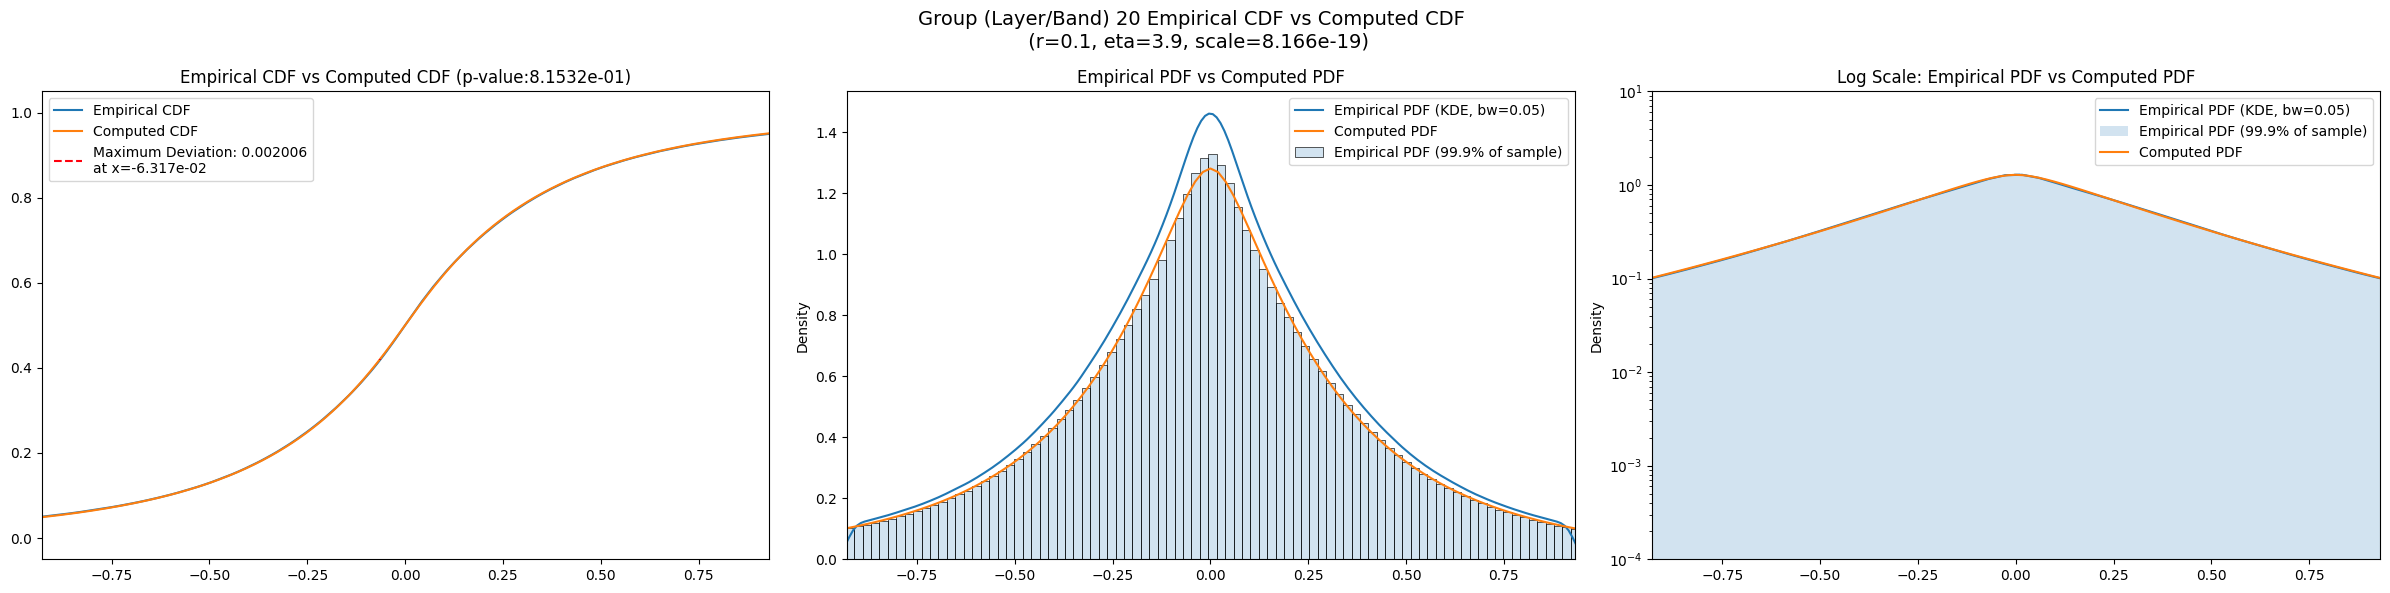

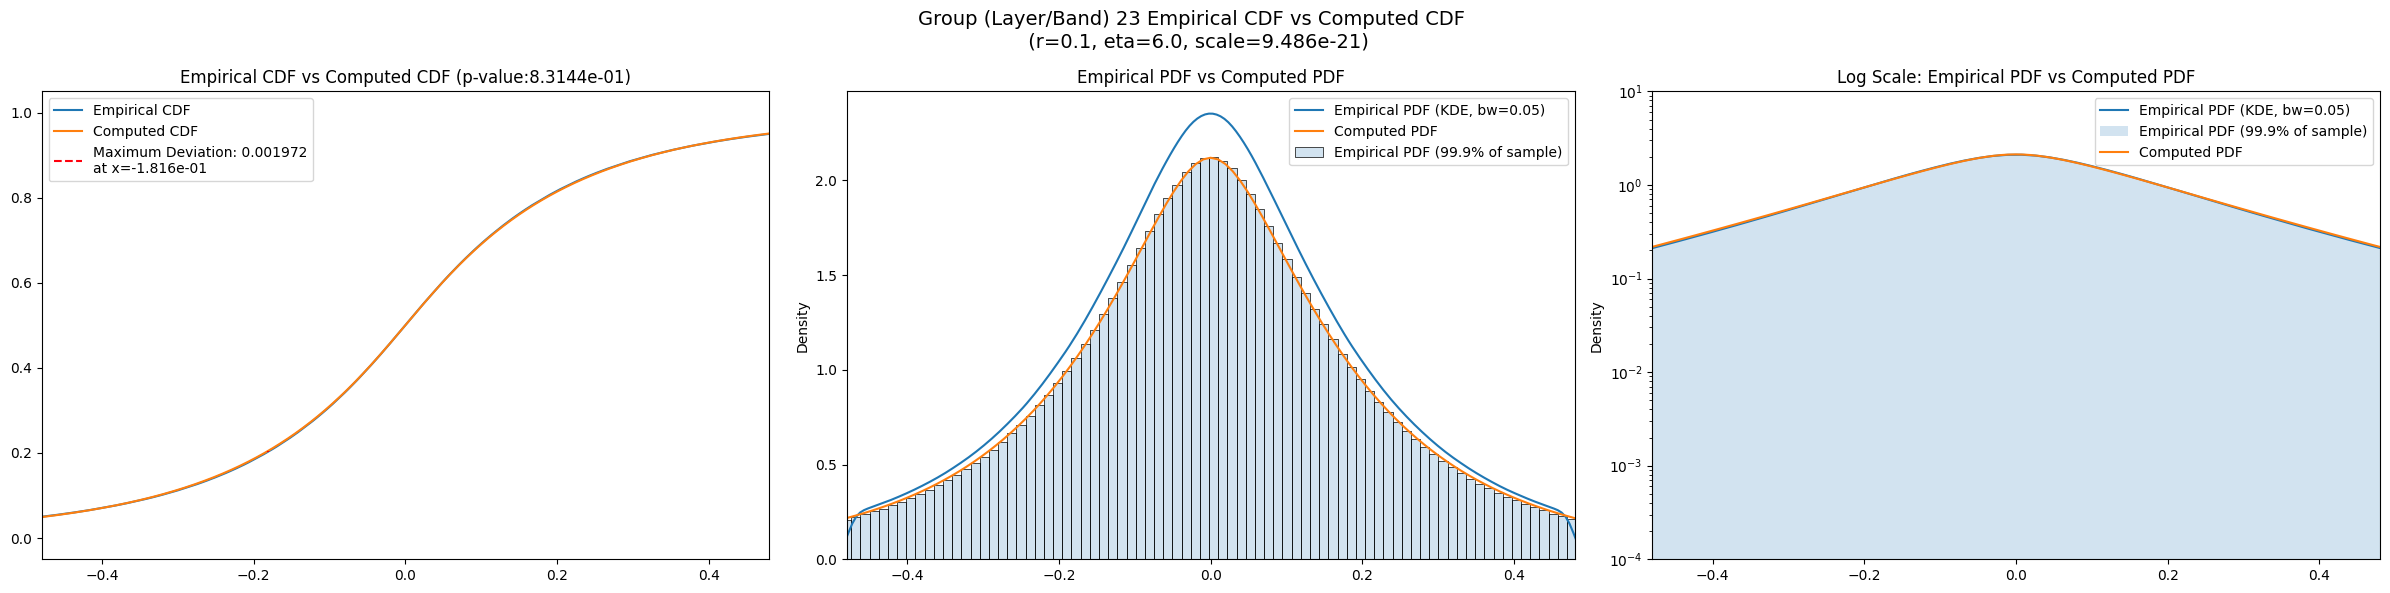

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower    var_upper    obs_kurt  kurt_lower  \
band                                                                  
2     1179.389800  1097.971300  1266.585400    5.769592    4.088153   
5      437.022400   401.945200   476.607120    8.911059    5.411635   
8      126.231570   115.505930   139.046250   10.603689    5.844242   
11      33.334743    30.622417    36.353336    9.182022    5.623512   
14      10.371416     9.499190    11.419547   10.649118    5.947791   
17       2.548775     2.287402     3.145427   34.724674    6.520165   
20       0.429869     0.363122     0.795385  315.785900    6.707437   
23       0.100375     0.091152     0.128039   39.690784    4.401588   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
band                                                                            
2        8.210641        47614.0             0.005172        3.9         -0.9   
5       14.530110       102030.0             0.007780        2.0         -0.9   
8       28.603450       326496.0             0.006045        1.6         -0.9   
11      17.436111       904666.0             0.005868        1.7         -0.9   
14      27.891129      2727602.0             0.005238        0.8         -0.8   
17     200.073500      8298440.0             0.003934        0.6         -0.6   
20    1304.634400     25140192.0             0.001930        0.1          3.9   
23     247.719670     65734528.0             0.001812        0.1          6.0   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...       25.239000              0.035486          1.576350e-52   
5     ...       14.564800              0.037760         7.797850e-127   
8     ...        7.747660              0.036875          0.000000e+00   
11    ...        3.991170              0.036988          0.000000e+00   
14    ...        2.156520              0.039586          0.000000e+00   
17    ...        1.058120              0.038419          0.000000e+00   
20    ...        0.431716              0.035129          0.000000e+00   
23    ...        0.237652              0.028803          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
band                                                                       
2         21.287600             0.012075         1.852180e-06  17.943500   
5         12.209700             0.014785         8.362540e-20  10.169600   
8          6.561130             0.012684         4.675760e-46   5.378380   
11         3.399030             0.012363        1.539900e-120   2.759250   
14         1.871910             0.013562         0.000000e+00   1.485500   
17         0.927069             0.011844         0.000000e+00   0.732064   
20         0.380380             0.009058         0.000000e+00   0.304870   
23         0.205718             0.005190         0.000000e+00   0.168121   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.017166   1.282810e-12          1.559246e-01  
5          0.019197   4.302820e-33          1.786198e-05  
8          0.016137   2.793370e-74          7.107943e-09  
11         0.015718  1.457950e-194          4.398490e-21  
14         0.016523   0.000000e+00          3.284485e-61  
17         0.014979   0.000000e+00          1.071005e-93  
20         0.008862   0.000000e+00          9.530282e-82  
23         0.006323   0.000000e+00         8.175284e-188  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
band                                                                   
2                0.005172                 0.006220          0.005172   
5                0.007780                 0.004250          0.007546   
8                0.006045                 0.002376          0.005458   
11               0.005868                 0.001428          0.005127   
14               0.005238                 0.000822          0.005065   
17               0.003934                 0.000471          0.003597   
20               0.001930                 0.000271          0.001930   
23               0.001812                 0.000168          0.001812   

      kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
band                                                            
2                 0.035486             0.012075       0.017166  
5                 0.037760             0.014785       0.019197  
8                 0.036875             0.012684       0.016137  
11                0.036988             0.012363       0.015718  
14                0.039586             0.013562       0.016523  
17                0.038419             0.011844       0.014979  
20                0.035129             0.009058       0.008862  
23                0.028803             0.005190       0.006323

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
band                                                                         
2            1035.790600          0.005172    3.90     -0.90  2.902359e+03   
5             362.046936          0.007546    2.00     -0.91  9.423018e+02   
8             103.798401          0.005458    1.50     -0.88  2.319957e+02   
11             27.635000          0.005127    1.50     -0.88  6.176591e+01   
14              8.854065          0.005065    1.00     -0.85  1.362164e+01   
17              2.142538          0.003597    0.72     -0.70  1.526253e+00   
20              0.378706          0.001930    0.10      3.90  8.165637e-19   
23              0.095043          0.001812    0.10      6.00  9.486054e-21   

      best_exclude_cutoff  
band                       
2                   100.0  
5                   275.0  
8                   275.0  
11                  275.0  
14                  200.0  
17                  175.0  
20                   25.0  
23                   25.0

In [21]:
eng.quit()